# Wavelet denoising

Powerful signal processing technique that uses the wavelet transform to remove noise from signals. The fundamental idea is to transform the noisy signal into the wavelet domain, where it can be more effectively denoised by thresholding the wavelet coefficients, and then reconstructing the signal from the thresholded coefficients.

## Wavelet Denoising Steps
1. **Wavelet Decomposition:** Decompose the noisy signal into wavelet coefficients.
2. **Thresholding:** Apply a thresholding technique to the wavelet coefficients to remove noise.
3. **Inverse Wavelet Transform:** Reconstruct the denoised signal from the thresholded wavelet coefficients.

## Implementations

![waveletDenoiseImplementations](wavelet_denoise.png "Denoising Architectures")

### Denoise

Only removes the noise estimated from the higher frequency coefficients. It is the gold standart and the most implemented for ECG and PCG denoising. These implementations consider that the signals are already centered in 0

### Denoise 2

Takes the traditional denoising architecture, but forces the low frequency coefficients (approximation coefficients) to be 0, forcefully removing this information. For this approach to be effective, the decomposition levels must be carefully selected to eliminate the lower band frequencies. 

### Denoise 3

Includes the approximation coefficients into the thresholding, denoising this band as well. Detrends the Approximation Coefficients, removing the mean.

## Import Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import pywt
import pydub
import time
import sounddevice as sd
from scipy import signal
from biosppy.signals import ecg

## Denoisers Implementations

In [5]:
def classicWVDenoise(signal, family, level, threshold):
    wv_coeffs = pywt.wavedec(signal, wavelet=family, level=level)
    sigma = np.median(abs(wv_coeffs[-1]))/0.674
    for i in range(len(wv_coeffs)-1):
        lbda = threshold(wv_coeffs[i+1], sigma)
        wv_coeffs[i+1] = softThreshold (wv_coeffs[i+1], lbda)
    return pywt.waverec(wv_coeffs, wavelet=family)

def modifiedWVDenoise(signal, family, level, threshold):
    wv_coeffs = pywt.wavedec(signal, wavelet=family, level=level)
    sigma = np.median(abs(wv_coeffs[-1]))/0.674
    for i in range(len(wv_coeffs)-1):
        lbda = threshold(wv_coeffs[i+1], sigma)
        wv_coeffs[i+1] = softThreshold (wv_coeffs[i+1], lbda)
    wv_coeffs[0][:] = 0
    return pywt.waverec(wv_coeffs, wavelet=family)

def detrendedWVDenoise(signal, family, level, threshold):
    wv_coeffs = pywt.wavedec(signal, wavelet=family, level=level)
    sigma = np.median(abs(wv_coeffs[-1]))/0.674
    for i in range(len(wv_coeffs)):
        lbda = threshold(wv_coeffs[i], sigma)
        wv_coeffs[i] = softThreshold (wv_coeffs[i], lbda)
    wv_coeffs[0] -= np.mean(wv_coeffs[0])
    return pywt.waverec(wv_coeffs, wavelet=family)

## Functions

In [7]:
def softThreshold (signal, lbda):
    return np.sign(signal) * np.maximum(np.abs(signal) - lbda, 0)

def residuals (filtered, raw):
    return  raw - filtered[:len(raw)]

def rootMeanSquare(x):
    return np.sqrt(np.mean(x**2))

def meanSquareError(filtered, raw):
    filtered = np.array(filtered)
    raw = np.array(raw)
    return np.mean((raw - filtered[:len(raw)]) ** 2)

def signalPower(signal):
    return np.mean(signal **2)

def bandPassButterworth(data, a, b, order, rate, decimate=1):
    coefficients = signal.butter(order, [a, b], btype="bandpass", output="sos", fs=rate)
    filt = signal.sosfiltfilt(coefficients, data)
    return signal.decimate(filt, decimate)

def lowPassButterworth(data, a, order, rate, decimate=1):
    coefficients = signal.butter(order, a, btype="lowpass", output="sos", fs=rate)
    filt = signal.sosfiltfilt(coefficients, data)
    return signal.decimate(filt, decimate)

## SNR  Implementations

Being **X** a Random Variable originated from an LTI system with a $pdf = f_X(x)$, the total power can be expressed as :

$$E\left\{ X^2 \right\} = E\left\{ \left( X-\mu_x \right)^2 \right\} + E\left\{ X \right\}^2 = \sigma_X^2 + \mu_X^2$$

Where:
- $\sigma_X^2$ represents the AC power
- $\mu_X^2$ represents the DC power

In [10]:
def detrendedSNR(signal, noise):
    # DC power SNR
    dc_signal_power = (np.mean(signal)) ** 2
    dc_noise_power = (np.mean(noise)) ** 2
    snr_dc_power = 10 * np.log10(dc_signal_power / dc_noise_power)
    # AC power SNR
    ac_signal_power = np.var(signal)
    ac_noise_power = np.var(noise)
    snr_ac_power = 10 * np.log10(ac_signal_power / ac_noise_power)
    return np.array([snr_dc_power, snr_ac_power])

def totalPowerSNR(signal, noise):
    total_signal_power = signalPower(signal)
    total_noise_power = signalPower(noise)
    snr_total_power = 10 * np.log10(total_signal_power / total_noise_power)
    return snr_total_power

Instead of detrending, one can divide the signal and noise into low frequency and hight frequency, considering the separation of the baseline wandering. Equally to the previous approach, the more negative the low frequency or DC component is, the better the filtering.

In [12]:
def frequencySNR(denoised_signal, noise, fc):
    coefficients_lp = signal.ellip(6, rp=1, rs=20, Wn=fc, btype="lowpass", output="sos", fs=500)
    coefficients_hp = signal.ellip(6, rp=1, rs=20, Wn=fc, btype="highpass", output="sos", fs=500)

    # Low frequency power SNR
    low_signal = signal.sosfilt(coefficients_lp, denoised_signal)
    low_noise = signal.sosfilt(coefficients_lp, noise)
    snr_low_power = totalPowerSNR(low_signal, low_noise)
    # High Frequency power SNR
    high_signal = signal.sosfilt(coefficients_hp, denoised_signal)
    high_noise = signal.sosfilt(coefficients_hp, noise)
    snr_high_power = totalPowerSNR(high_signal, high_noise)
    return np.array([snr_low_power, snr_high_power])

# Lambda estimators

### Universal Lambda (VisuShrink)

**Ideal for denoising signals corrupted by Gaussian white noise**

$$\lambda = \sigma \sqrt{2*log\left( n \right)}$$

- $\sigma$ estimated noise
- $n$ number of data points in the signal

The estimated noise $\sigma$ obtainned suing the median absolute deviation (MAD) of the wavelet detail coefficients at the finest scale:

$$\sigma = \frac{median\left( \left| d_1 \right| \right)}{0.6745}$$

In [15]:
def universal(coeffs, sigma):
    n = len(coeffs)
    return sigma * np.sqrt(2*np.log(n))

### miniMax Threshold

**Theory:**

The minimax threshold is derived from the minimax principle in statistical decision theory, which aims to minimize the maximum possible error. It is often used when the signal length is relatively small.

It minimizes the maximum risk in estimation, Balances noise reduction and signal presetvation, but i'ts less adaptive to varying noise

**Governing Formula:**

The minimax threshold $\lambda$ is given by preset values depending on the length of the signal:

- For $n < 32: \lambda = 0$
- For $32 \le n < 1024: \lambda = 0.3936 + 0.1829 \: log_2(n)$
- For $n \ge 1024: \lambda = 0.3936 + 0.2365 \: log_2(n)$


In [17]:
def miniMaxLambda(coeffs, sigma):
    n = len(coeffs) 
    if n < 32:
        lbda = 0
    elif n < 1024:
        lbda = 0.3936 + 0.1829 * np.log2(n)
    else:
        lbda = 0.3936 + 0.2365 * np.log2(n)
    return lbda

### SURE Threshold (Stein's Unbiased Risk Estimate)

**Theory:**

SURE (Stein's Unbiased Risk Estimate) thresholding is an adaptive method that estimates the threshold by minimizing an unbiased estimate of the risk (mean squared error). It is data-driven and adapts to the underlying signal and noise characteristics.

Adaptive denoising, adapts to data, minimizes risk estimation, but it's computationally intensive

**Governing Formula:**

The SURE threshold $\lambda_{SURE}$ is found by minimizing the SURE risk estimate:

$$SURE\left( \lambda \right)=n\sigma^2+\sum_{i=1}^{n}min\left( \left| x_i \right|^2, \lambda^2 \right)-2\sigma^2\sum_{i=1}^{n}I\left( \left| x_i \right| \le \lambda \right)$$

where:
- $n$ is the number of data points
- $\sigma$ is the noise standard deviation
- $x_i$ are the wavelet coefficients
- $I(\cdot)$ is the indicator function

In [19]:
def sureLambda(coeffs, sigma):
    n = len(coeffs)
    # Definse SURE function for a given lambda
    def sure(lambda_val):
        term1 = n * sigma**2
        term2 = np.sum(np.minimum(coeffs**2, lambda_val**2)) - sigma**2
        term3 = 2 * sigma**2 * np.sum(np.abs(coeffs) <= lambda_val)
        return term1 + term2 + term3
    # Grid search for optimal lambda
    lambdas = np.linspace(0, np.max(np.abs(coeffs)),1000)
    sure_values = np.array([sure(lambda_val) for lambda_val in lambdas])
    optimal_lambda = lambdas[np.argmin(sure_values)]
    return optimal_lambda
    

### BayesShrink
[http://irphouse.com/ijeee/ijeeev8n1_04.pdf]


Estimates the threshold $\lambda$ for each sub-band baseddd on the noise variannce and the signal variance. The key idea is to apply a threshold that adapts to the characteristics of the data in each sub-band

For this context:

- $\beta$ are the wavelet coefficients of the noisy signal
- **Noise variance** $\sigma^2$, assumes that the noise is typically Gausian with zero mean and variance $\sigma^2$
- $\sigma$ can be estimated from the detail coefficients at the finest scale using the median absolute deviation (MAD)
- **Signal Variance** r$\sigma_s^2$, is etimated from the noisy wavelet coefficients as:
  $$\hat{\sigma}_s^2=max\left( \frac{1}{n}\sum_{i=1}^{n}\beta_i^2-\hat{\sigma}^2, 0 \right)$$

  where $n$ is the number of coefficients in the sub-band
- The BayesShrink threshold is given by:
  $$\lambda=\frac{\hat{\sigma}^2}{\sqrt{\hat{\sigma}_s^2}}$$

**Characteristics**

It adapts to data, *effective for non-Gaussian noise*, but requires estimation of noise variance

In [21]:
def bayesshrink_lambda(coeffs, sigma):  
    # Number of wavelet coefficients
    n = len(coeffs)
    
    # Estimate the signal variance (sigma_s^2)
    sigma_s_squared = np.maximum(np.mean((coeffs**2) - (sigma**2)), 0)
    
    # Calculate the BayesShrink threshold (lambda)
    if sigma_s_squared == 0:
        lambda_bayes = 0
    else:
        lambda_bayes = sigma**2 / np.sqrt(sigma_s_squared)
    
    return lambda_bayes

### NormalShrink
[https://www.ee.iitb.ac.in/~icvgip/PAPERS/202.pdf]

Very similar to universal and an extension of the BayesShrink

$$\lambda = \frac{\beta \hat{\sigma}^2}{\hat{\sigma}_y}$$

Where $\beta$  is a scale parameter:

$$\beta = \sqrt{log\left(\frac{N_k}{J}\right)}$$

$N_k$ is the lenght of the subband at the kth scale and $J$  is the total number of decompositions

$\hat{\sigma}^2$ is the noise variance, estiamted with MAD

and $\hat{\sigma}_y$ is the standard deviation of the subband under consideration.

In [23]:
def normalshrink_lambda(coeffs, sigma):  
    # Number of wavelet coefficients
    n = len(coeffs)
    beta = np.sqrt(np.log10(n/9))
    sigma_y = np.var(coeffs)

    lambda_normal = beta * (sigma ** 2) / sigma_y
    
    return lambda_normal

### FDR (False Discovery Rate) Thresholding

False Discovery Rate (FDR) thresholding is a statistical method used to control the expected proportion of false discoveries (false positives) among the rejected hypotheses. In the context of wavelet denoising, FDR thresholding aims to set thresholds for wavelet coefficients such that the proportion of noise coefficients mistakenly kept (false discoveries) is controlled at a desired level.

**Theoretical Explanation**

The FDR method for thresholding wavelet coefficients is based on the Benjamini-Hochberg procedure, which is commonly used in multiple hypothesis testing. The procedure controls the FDR by ordering the coefficients and comparing them to a threshold that adapts to the number of coefficients and the desired FDR level.

For this context:

- $\beta$ are the wavelet coefficients of the noisy signal
- **Noise Standard Deviation** $\sigma$ can be estimated from the detail coefficients at the finest scale using the median absolute deviation (MAD)
- Calculate the p-values for the wavelet coefficients assuming they follow a normal distribution:

  $$p_i = 2\left( 1-\Phi\left( \frac{\left| \beta_i \right|}{\sigma} \right) \right)$$

  where $\Phi$ is the cumulative distribution functino (CDF) of the standard normal distribution

- **FDR Threshold ($\lambda$)**:
    - Sort the p-values in ascending order: $p_{(1)} \le p_{(2)} \le \cdots \le p_{(n)}$
    - Determine the largest index $k$ such as that:

      $$p_{(k)} \le \frac{k \cdot q}{n}$$

      where $q$ is the desired FDR level and $n$ is the number of coefficients.
    - The FDR threshold is:
 
      $$\lambda = \frac{\left| \beta_{(k)} \right|}{\sigma}$$


In [25]:
def fdr_lambda(coeffs, sigma, q=0.05):

    n = len(coeffs)
    # Calculate p-values for the wavelet coefficients
    p_values = 2 * (1 - stats.norm.cdf(np.abs(coeffs) / sigma))
    
    # Sort p-values in ascending order
    sorted_p_values = np.sort(p_values)
    
    # Determine the largest k such that p_(k) <= k * q / n
    thresholds = np.arange(1, n + 1) * q / n
    significant = sorted_p_values <= thresholds
    if np.any(significant):
        k = np.max(np.where(significant)[0]) + 1
        lambda_fdr = sorted_p_values[k - 1] * sigma / stats.norm.ppf(1 - sorted_p_values[k - 1] / 2)
    else:
        lambda_fdr = 0
    
    return lambda_fdr

### Import signal

[]

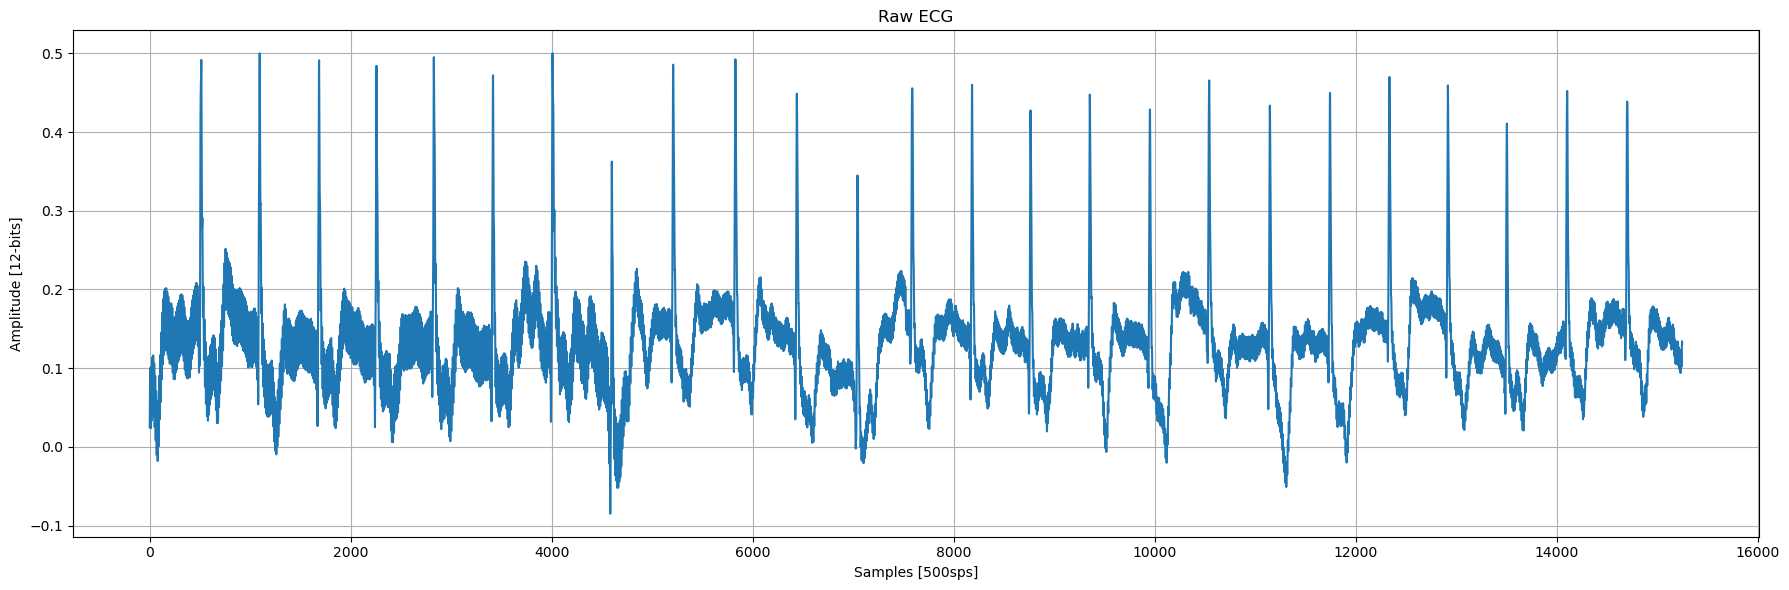

In [27]:
#%% Import signals

# Declare files path
PCG_path = r"C:/Users/danie/Dropbox/PhD/SignalQuality/DatasetCHVNGE/37_MV.mp3"
ECG_path = r"C:/Users/danie/Dropbox/PhD/SignalQuality/DatasetCHVNGE/37_MV.raw"

## Import PCG
a = pydub.AudioSegment.from_mp3(PCG_path)
PCG_rate = a.frame_rate
t = a.duration_seconds
PCG = np.array(a.get_array_of_samples())
PCG_bit_width = 16
PCG_resolution = (2 ** PCG_bit_width)-1

## Import ECG
ECG = np.loadtxt(ECG_path, delimiter=",", dtype=int)
ECG_rate = 500
ECG_bit_width = 12
ECG_resolution = (2 ** ECG_bit_width)-1

## Normalize full-scale
ECG_v = (ECG - ECG_resolution/2) / (ECG_resolution) #int 12 bits (scale -0.5;0.5)

plt.figure(figsize=(18, 6))
plt.plot(ECG_v)
plt.grid()
plt.xlabel('Samples [500sps]')
plt.ylabel('Amplitude [12-bits]')
plt.title('Raw ECG')
plt.tight_layout()

plt.plot()

# Universal (VisuShrink) Filtering

## Denoise 1

Text(0.02, 0.5, 'Amplitude [normalized]')

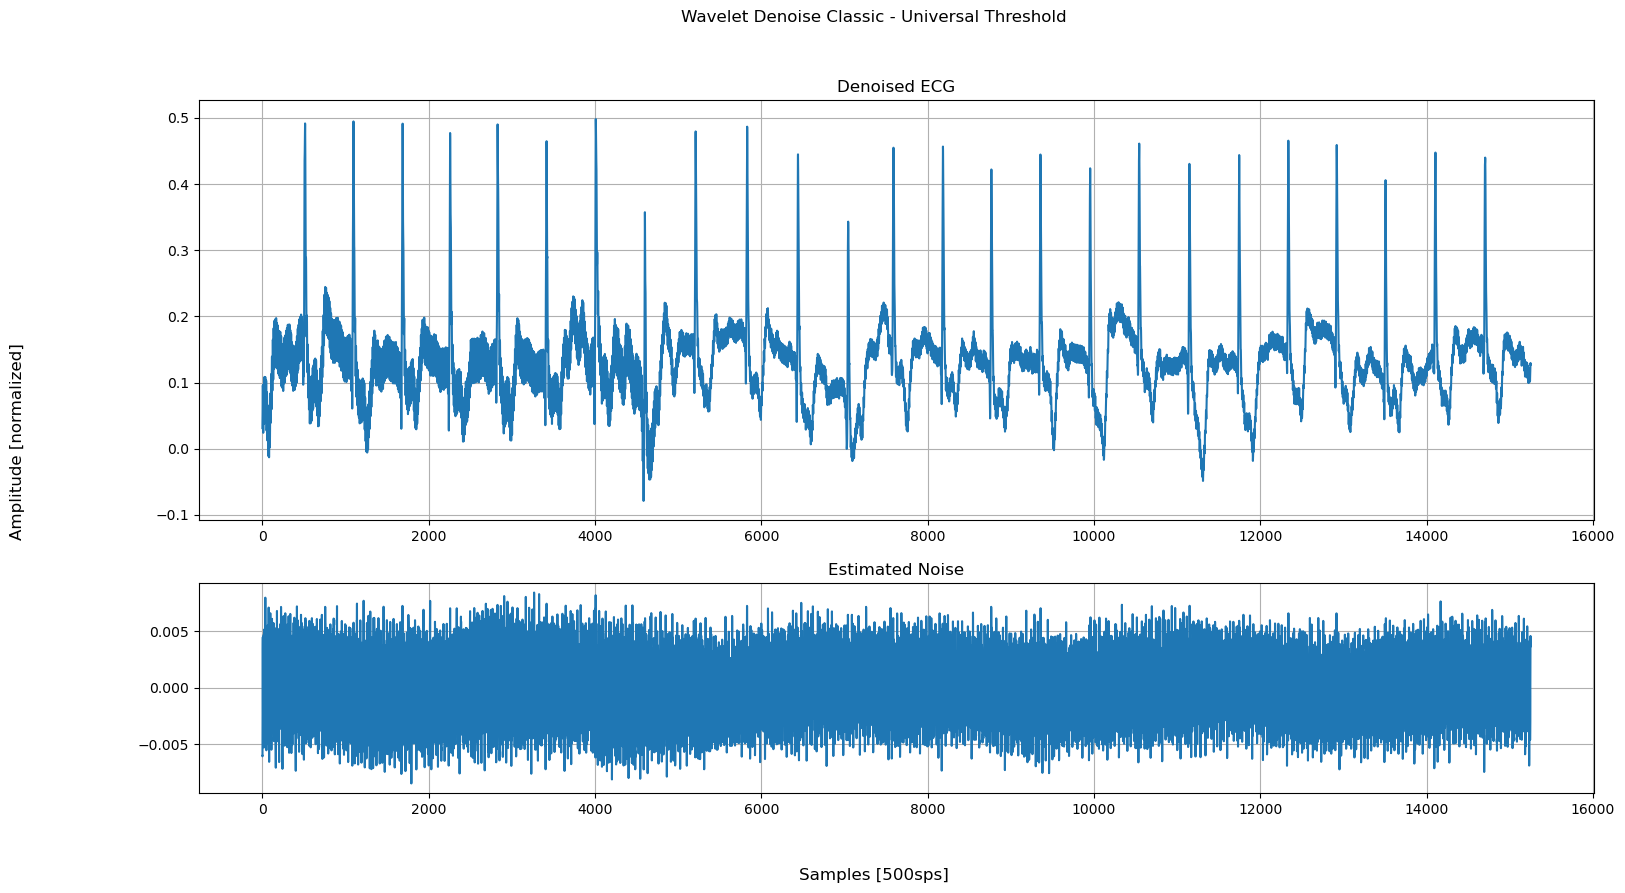

In [30]:
# Signal Denoise
ECG_wv_universal1 = classicWVDenoise(ECG_v, 'db4', 5, universal)
e_universal_1 = residuals (ECG_wv_universal1, ECG_v)

# noise level metrics
mse_universal1 =  meanSquareError(ECG_wv_universal1, ECG_v)
dc_snr_universal_1, ac_snr_universal_1 = detrendedSNR(ECG_wv_universal1, e_universal_1)
lf_snr_universal_1, hf_snr_universal_1 = frequencySNR(ECG_wv_universal1, e_universal_1, 0.5)

# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('Wavelet Denoise Classic - Universal Threshold')
axs[0].plot(ECG_wv_universal1)
axs[0].set_title('Denoised ECG')
axs[0].grid()
axs[1].plot(e_universal_1)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [500sps]')
fig.supylabel('Amplitude [normalized]')

## Denoise 2

Here I go down 0 levels since the ECG is defined between 0.5 - 150 Hz

- lv0: DC - 250Hz
- lv1: DC - 125Hz
- lv2: DC - 62.5Hz
- lv3: DC - 31.25Hz
- lv4: DC - 15.63Hz
- lv5: DC - 7.81Hz
- lv6: DC - 3.9Hz
- lv7: DC - 1.95Hz
- lv8: DC - 0.98Hz
- lv9: DC - 0.49Hz

Text(0.02, 0.5, 'Amplitude [normalized]')

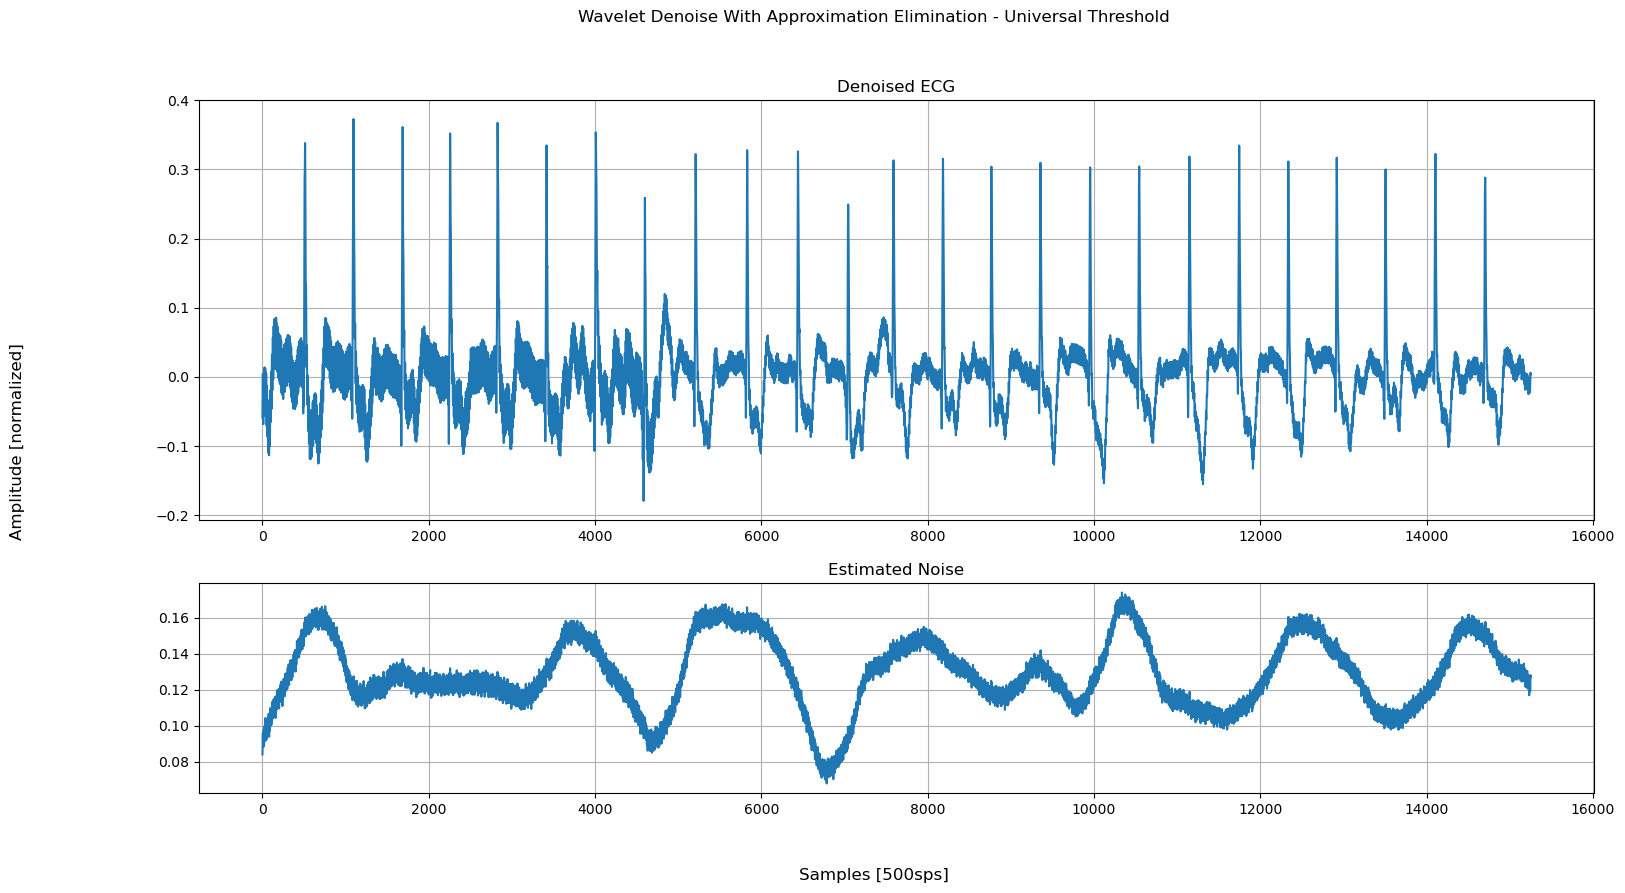

In [32]:
# Signal Denoise
ECG_wv_universal2 = modifiedWVDenoise(ECG_v, 'db4', 9, universal)
e_universal_2 = residuals (ECG_wv_universal2, ECG_v)
# noise level metrics
mse_universal2 =  meanSquareError(ECG_wv_universal2, ECG_v)
dc_snr_universal_2, ac_snr_universal_2 = detrendedSNR(ECG_wv_universal2, e_universal_2)
lf_snr_universal_2, hf_snr_universal_2 = frequencySNR(ECG_wv_universal2, e_universal_2, 0.5)

# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('Wavelet Denoise With Approximation Elimination - Universal Threshold')
axs[0].plot(ECG_wv_universal2)
axs[0].set_title('Denoised ECG')
axs[0].grid()
axs[1].plot(e_universal_2)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [500sps]')
fig.supylabel('Amplitude [normalized]')

## Denoise 3

Text(0.02, 0.5, 'Amplitude [normalized]')

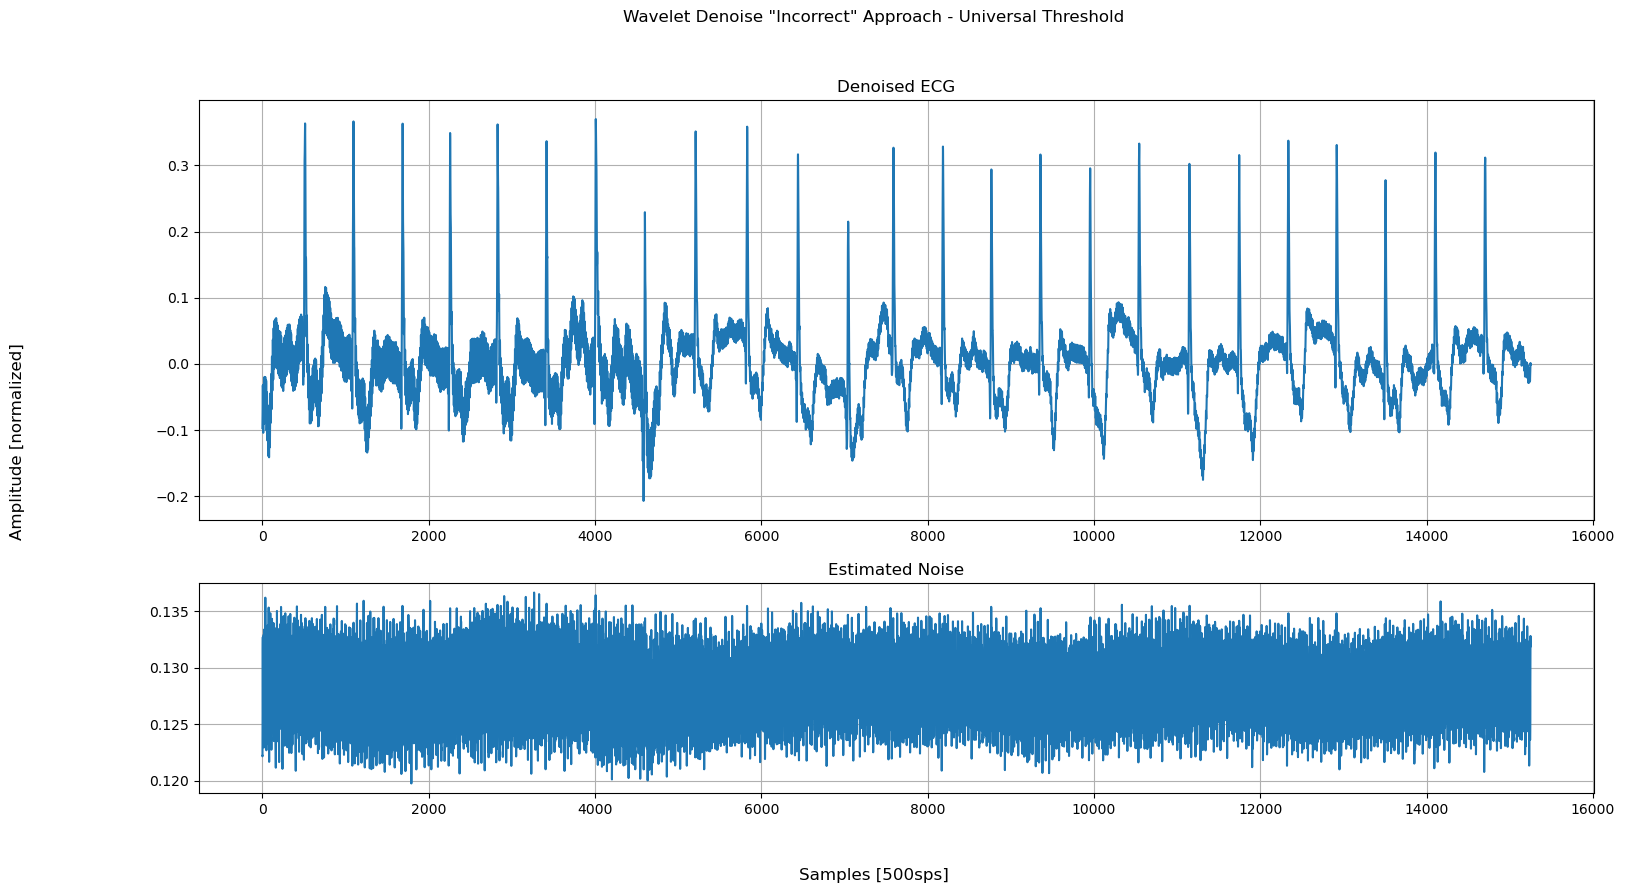

In [34]:
# Signal Denoise
ECG_wv_universal3 = detrendedWVDenoise(ECG_v, 'db4', 5, universal)
e_universal_3 = residuals (ECG_wv_universal3, ECG_v)
# noise level metrics
mse_universal3 =  meanSquareError(ECG_wv_universal3, ECG_v)
dc_snr_universal_3, ac_snr_universal_3 = detrendedSNR(ECG_wv_universal3, e_universal_3)
lf_snr_universal_3, hf_snr_universal_3 = frequencySNR(ECG_wv_universal3, e_universal_3, 0.5)

# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('Wavelet Denoise "Incorrect" Approach - Universal Threshold')
axs[0].plot(ECG_wv_universal3)
axs[0].set_title('Denoised ECG')
axs[0].grid()
axs[1].plot(e_universal_3)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [500sps]')
fig.supylabel('Amplitude [normalized]')

# MiniMax Denoising

Text(0.02, 0.5, 'Amplitude [12-bits]')

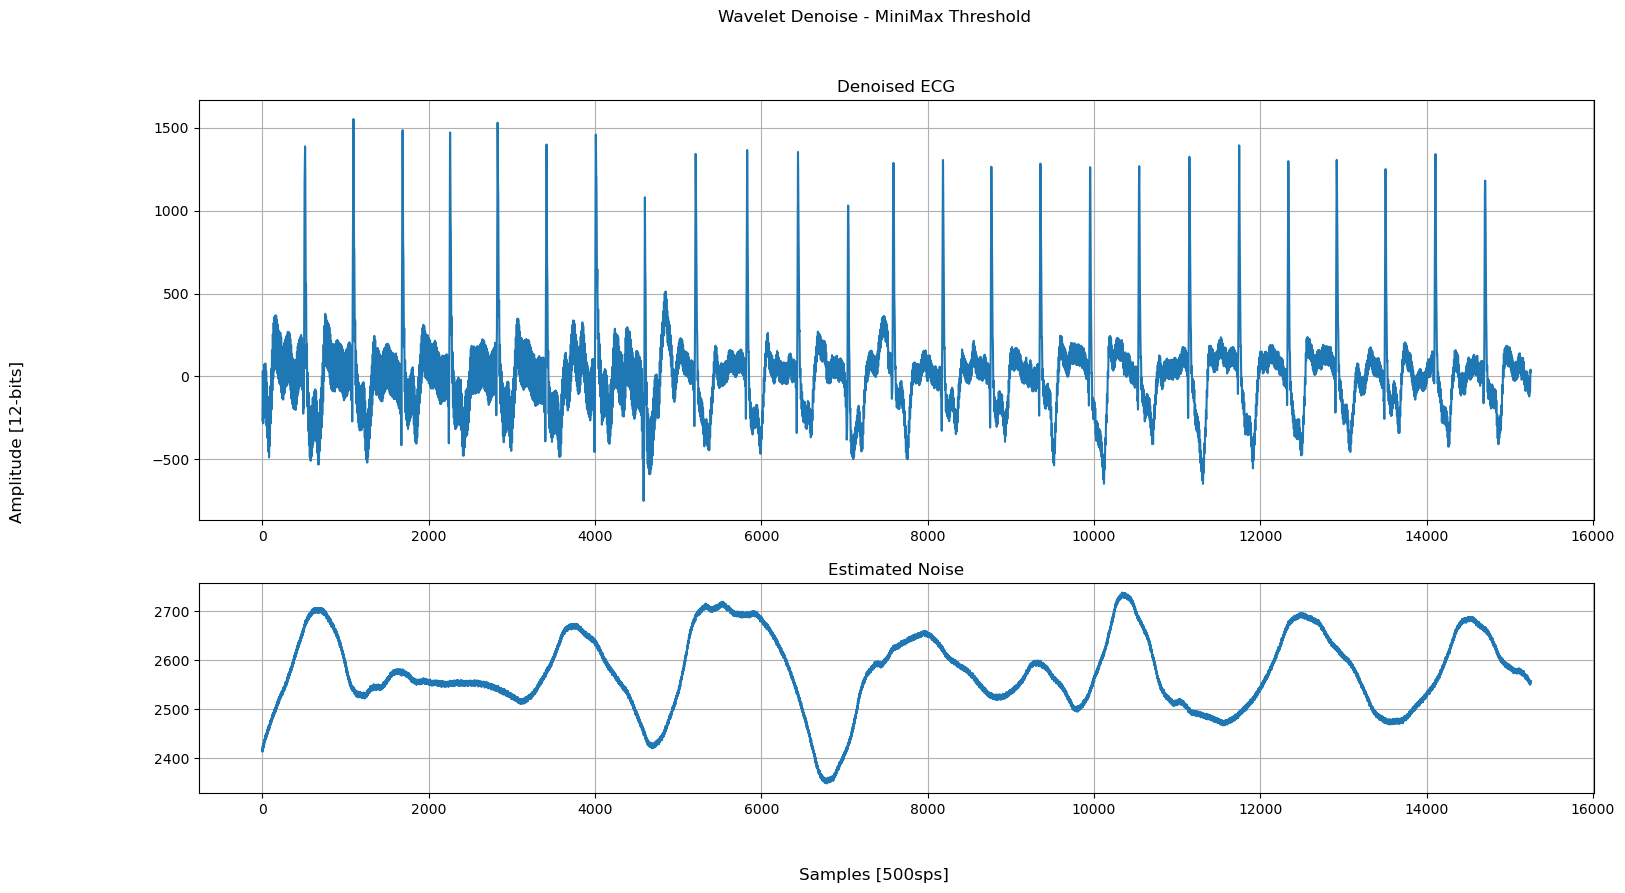

In [36]:
# Signal Denoise
ECG_wv_minimax = modifiedWVDenoise(ECG, 'db4', 9, miniMaxLambda)
e_minimax = residuals (ECG_wv_minimax, ECG)
# noise level metrics
mse_minimax =  meanSquareError(ECG_wv_minimax, ECG)
dc_snr_minimax, ac_snr_minimax = detrendedSNR(ECG_wv_minimax, e_minimax)
lf_snr_minimax, hf_snr_minimax = frequencySNR(ECG_wv_minimax, e_minimax, 0.5)

# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('Wavelet Denoise - MiniMax Threshold')
axs[0].plot(ECG_wv_minimax)
axs[0].set_title('Denoised ECG')
axs[0].grid()
axs[1].plot(e_minimax)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [500sps]')
fig.supylabel('Amplitude [12-bits]')

Only works with data not normalized

# SURE Denoising

Text(0.02, 0.5, 'Amplitude [normalized]')

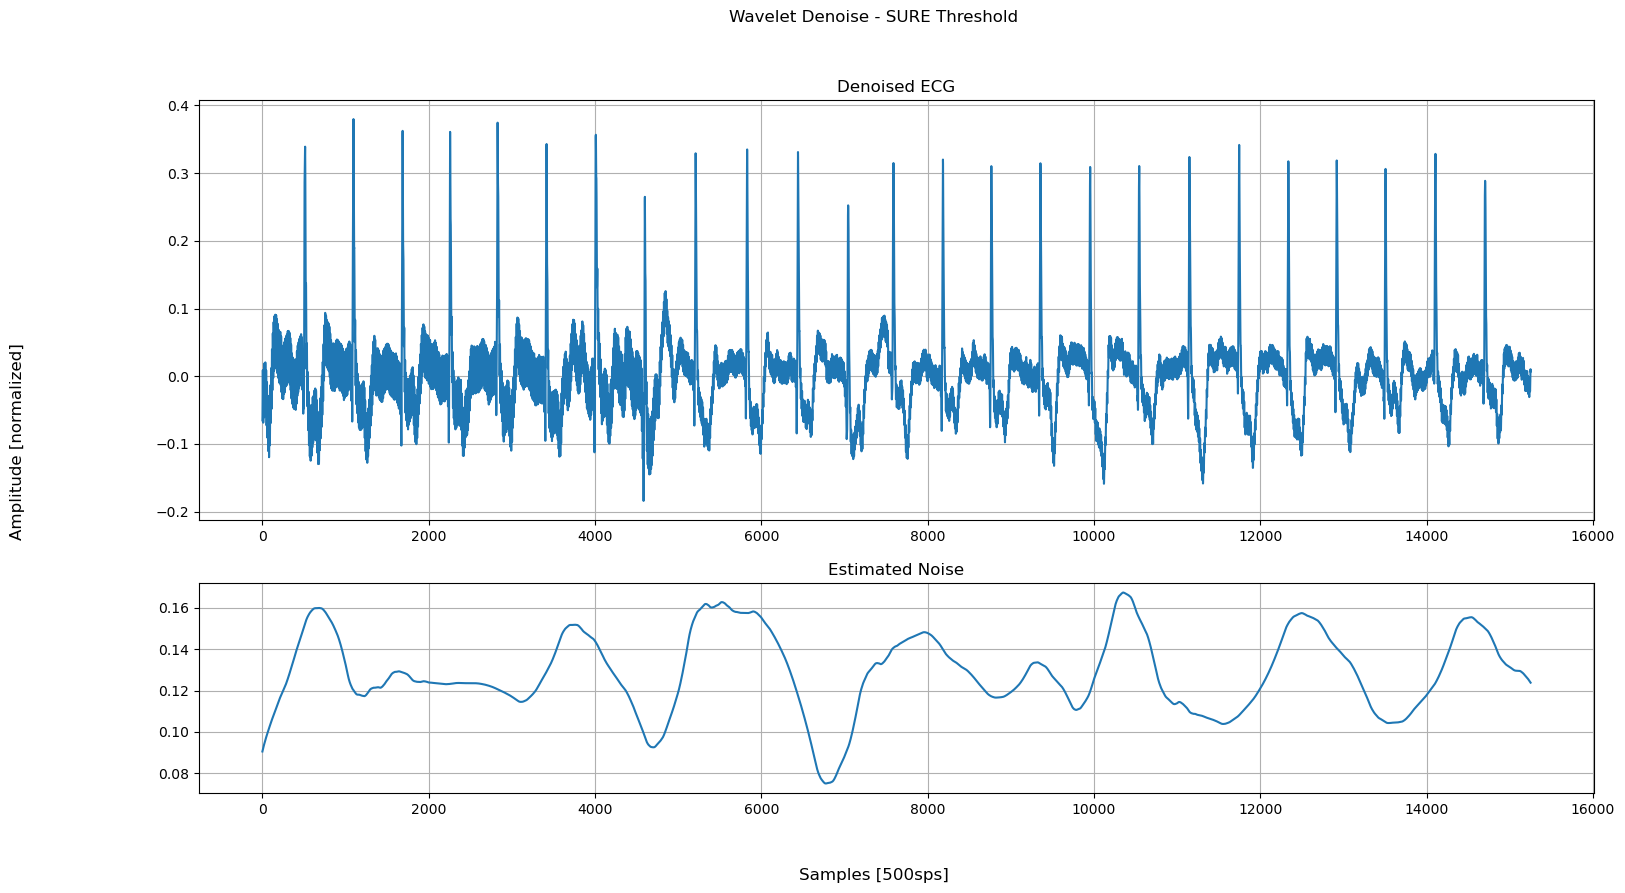

In [39]:
# Signal Denoise
ECG_wv_sure = modifiedWVDenoise(ECG_v, 'db4', 9, sureLambda)
e_sure = residuals (ECG_wv_sure, ECG_v)
# noise level metrics
mse_sure =  meanSquareError(ECG_wv_sure, ECG_v)
dc_snr_sure, ac_snr_sure = detrendedSNR(ECG_wv_sure, e_sure)
lf_snr_sure, hf_snr_sure = frequencySNR(ECG_wv_sure, e_sure, 0.5)

# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('Wavelet Denoise - SURE Threshold')
axs[0].plot(ECG_wv_sure)
axs[0].set_title('Denoised ECG')
axs[0].grid()
axs[1].plot(e_sure)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [500sps]')
fig.supylabel('Amplitude [normalized]')

# BayesShrink Denoising

Text(0.02, 0.5, 'Amplitude [normalized]')

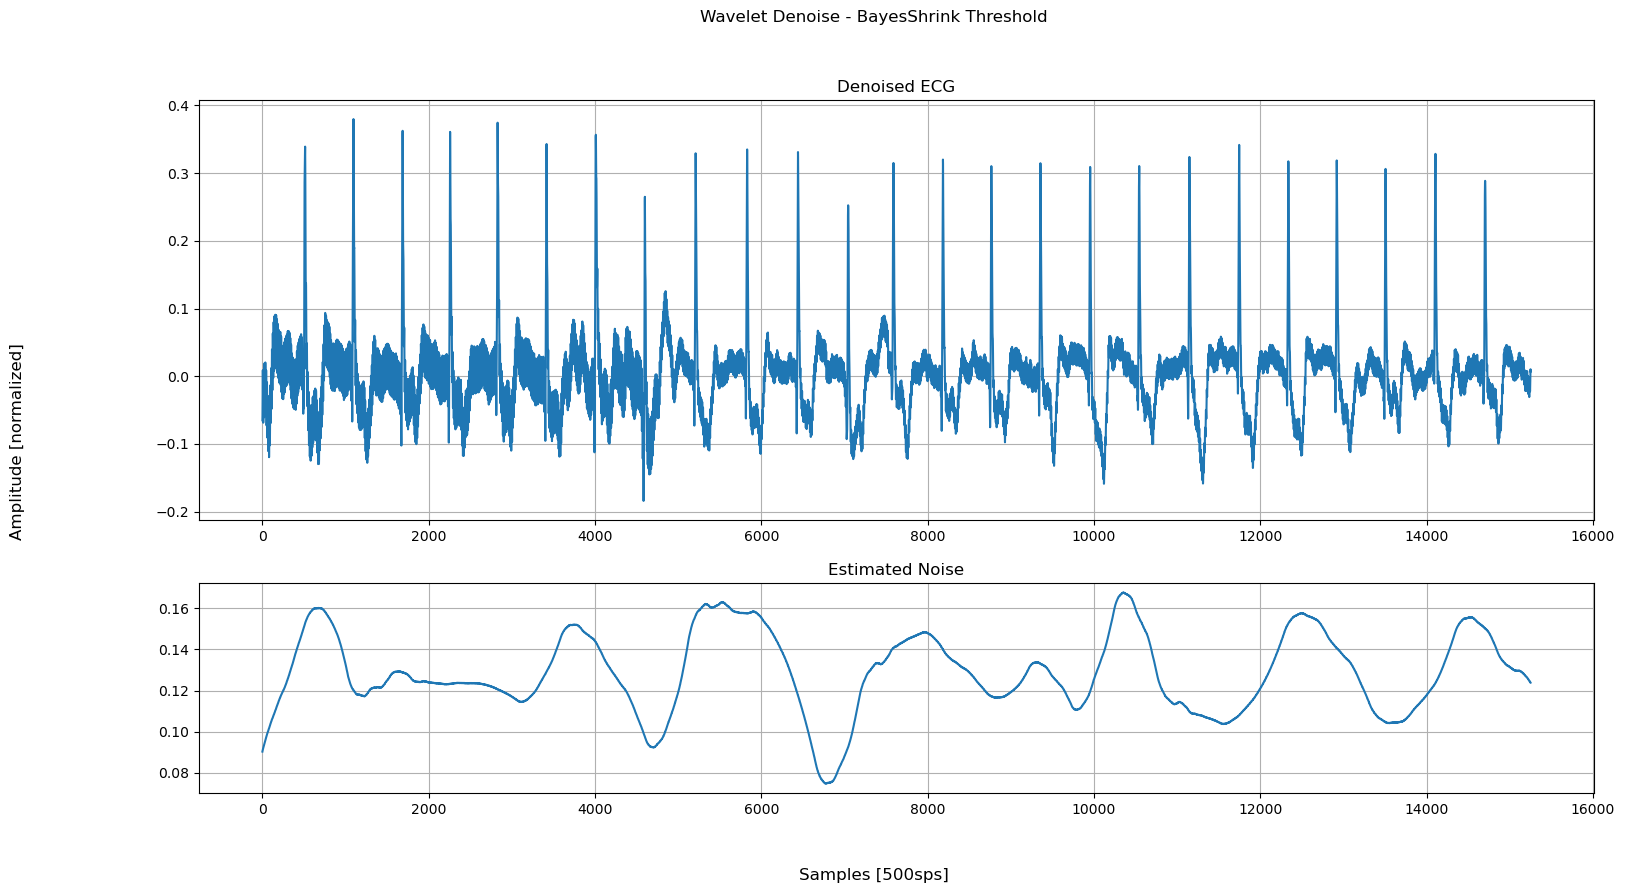

In [41]:
# Signal Denoise
ECG_wv_bayeshrink = modifiedWVDenoise(ECG_v, 'db4', 9, bayesshrink_lambda)
e_bayeshrink = residuals (ECG_wv_bayeshrink, ECG_v)
# noise level metrics
mse_bayeshrink =  meanSquareError(ECG_wv_bayeshrink, ECG_v)
dc_snr_bayeshrink, ac_snr_bayeshrink = detrendedSNR(ECG_wv_bayeshrink, e_bayeshrink)
lf_snr_bayeshrink, hf_snr_bayeshrink = frequencySNR(ECG_wv_bayeshrink, e_bayeshrink, 0.5)

# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('Wavelet Denoise - BayesShrink Threshold')
axs[0].plot(ECG_wv_bayeshrink)
axs[0].set_title('Denoised ECG')
axs[0].grid()
axs[1].plot(e_bayeshrink)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [500sps]')
fig.supylabel('Amplitude [normalized]')

# NormalShrink Denoising

Text(0.02, 0.5, 'Amplitude [normalized]')

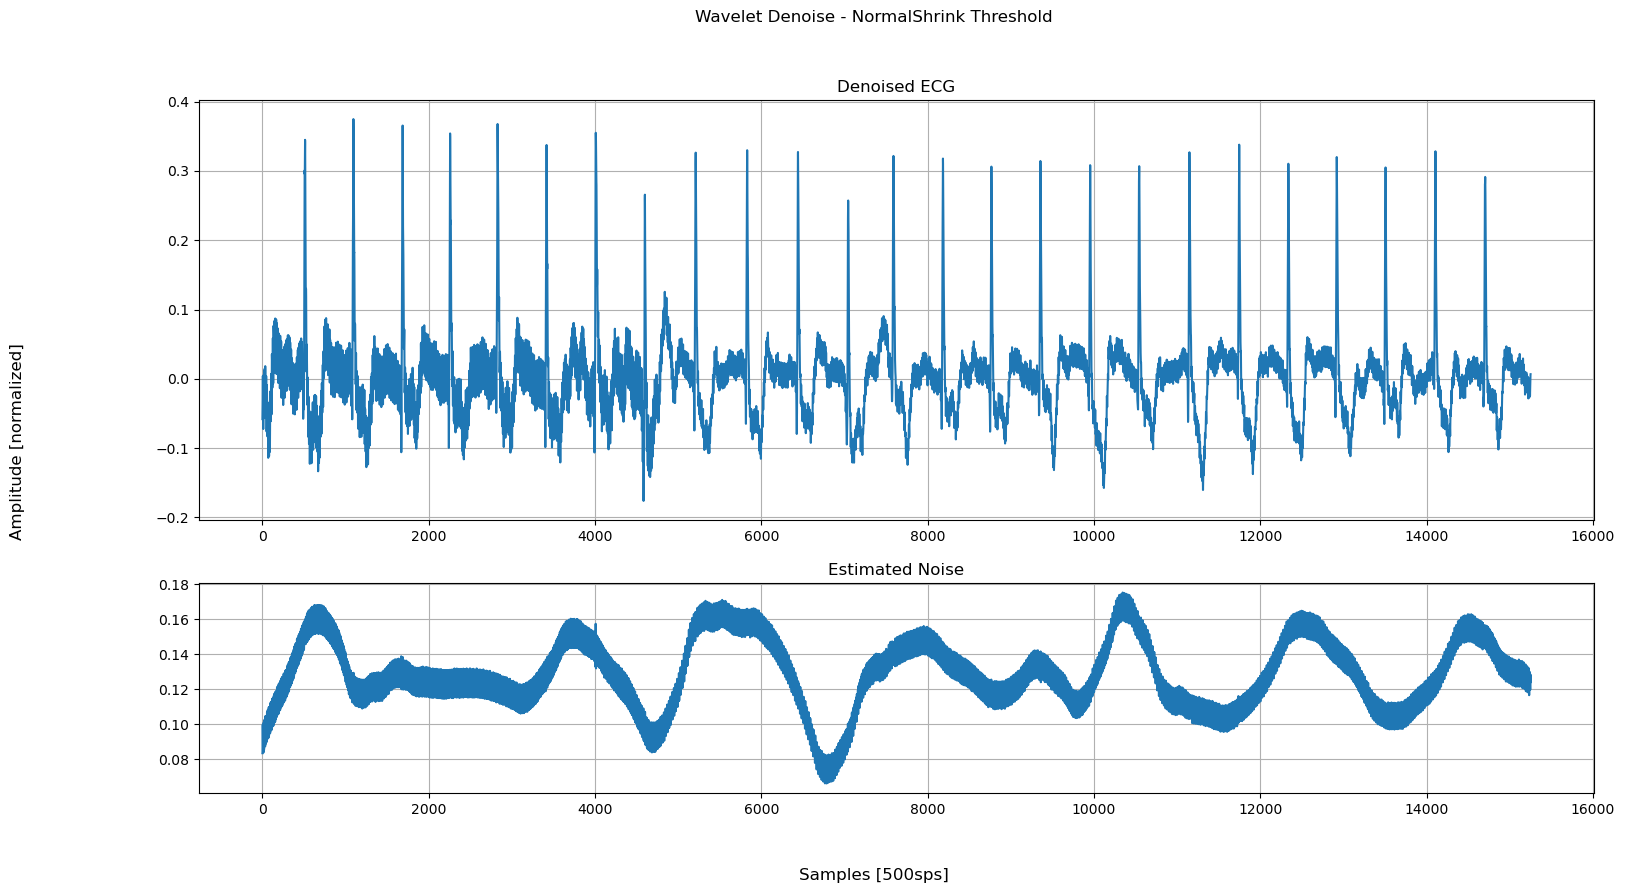

In [43]:
# Signal Denoise
ECG_wv_normalshrink = modifiedWVDenoise(ECG_v, 'db4', 9, normalshrink_lambda)
e_normalshrink = residuals (ECG_wv_normalshrink, ECG_v)
# noise level metrics
mse_normalshrink =  meanSquareError(ECG_wv_normalshrink, ECG_v)
dc_snr_normalshrink, ac_snr_normalshrink = detrendedSNR(ECG_wv_normalshrink, e_normalshrink)
lf_snr_normalshrink, hf_snr_normalshrink = frequencySNR(ECG_wv_normalshrink, e_normalshrink, 0.5)

# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('Wavelet Denoise - NormalShrink Threshold')
axs[0].plot(ECG_wv_normalshrink)
axs[0].set_title('Denoised ECG')
axs[0].grid()
axs[1].plot(e_normalshrink)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [500sps]')
fig.supylabel('Amplitude [normalized]')

# FDR Threshold Denoising

Text(0.02, 0.5, 'Amplitude [normalized]')

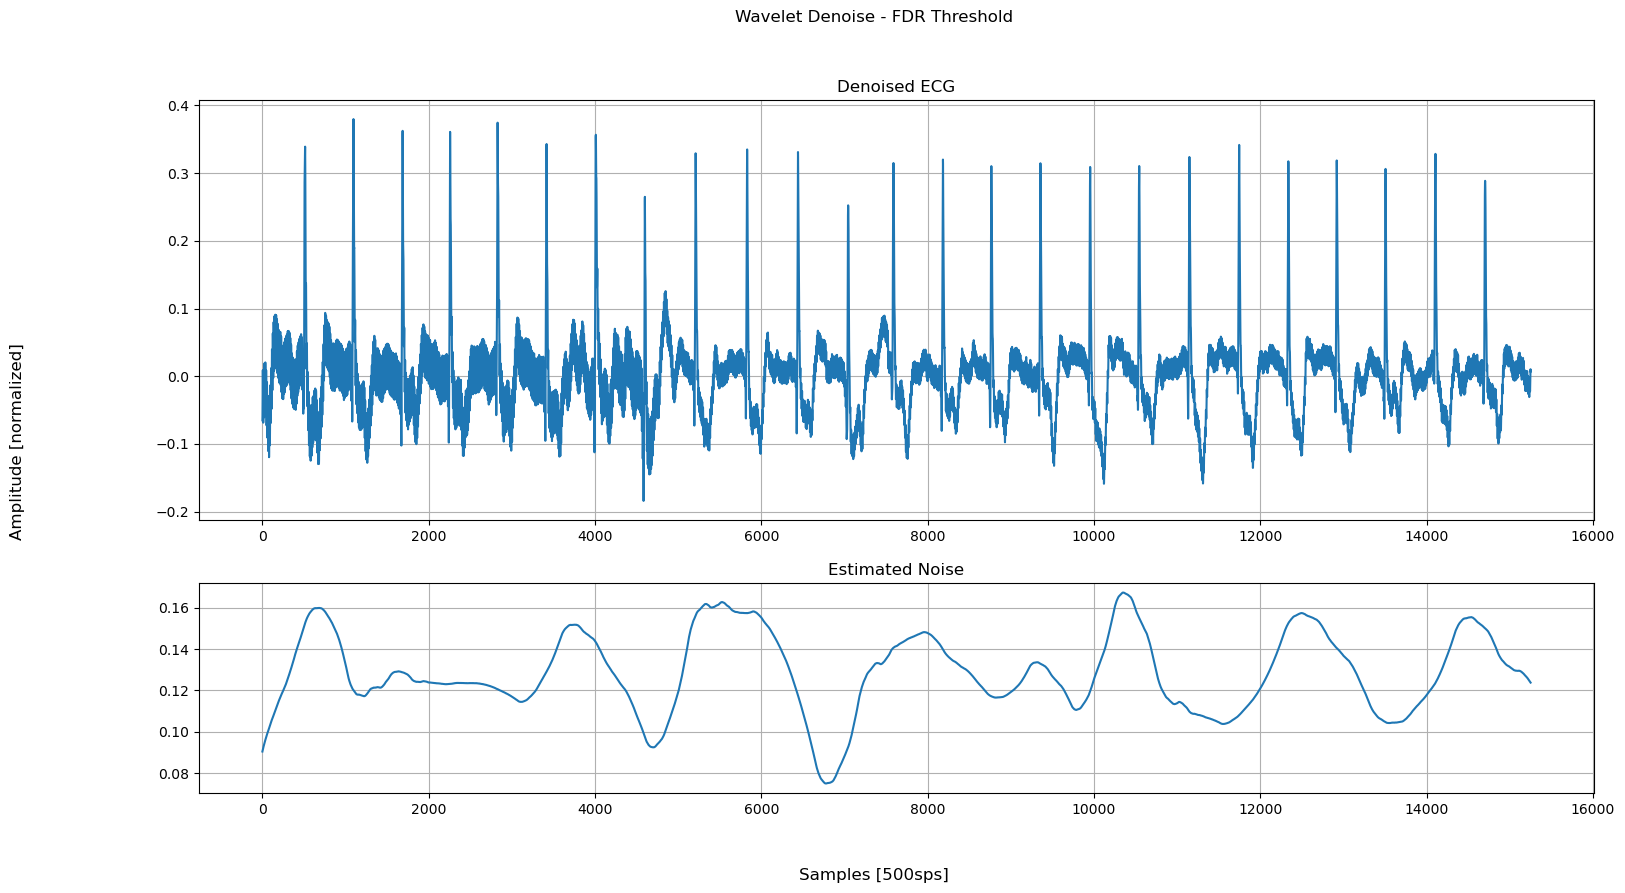

In [45]:
# Signal Denoise
ECG_wv_fdr = modifiedWVDenoise(ECG_v, 'db4', 9, fdr_lambda)
e_fdr = residuals (ECG_wv_fdr, ECG_v)
# noise level metrics
mse_fdr =  meanSquareError(ECG_wv_fdr, ECG_v)
dc_snr_fdr, ac_snr_fdr = detrendedSNR(ECG_wv_fdr, e_fdr)
lf_snr_fdr, hf_snr_fdr = frequencySNR(ECG_wv_fdr, e_fdr, 0.5)

# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('Wavelet Denoise - FDR Threshold')
axs[0].plot(ECG_wv_fdr)
axs[0].set_title('Denoised ECG')
axs[0].grid()
axs[1].plot(e_fdr)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [500sps]')
fig.supylabel('Amplitude [normalized]')

# Control Filteling

## Linear phase FIR

Text(0.02, 0.5, 'Amplitude [normalized]')

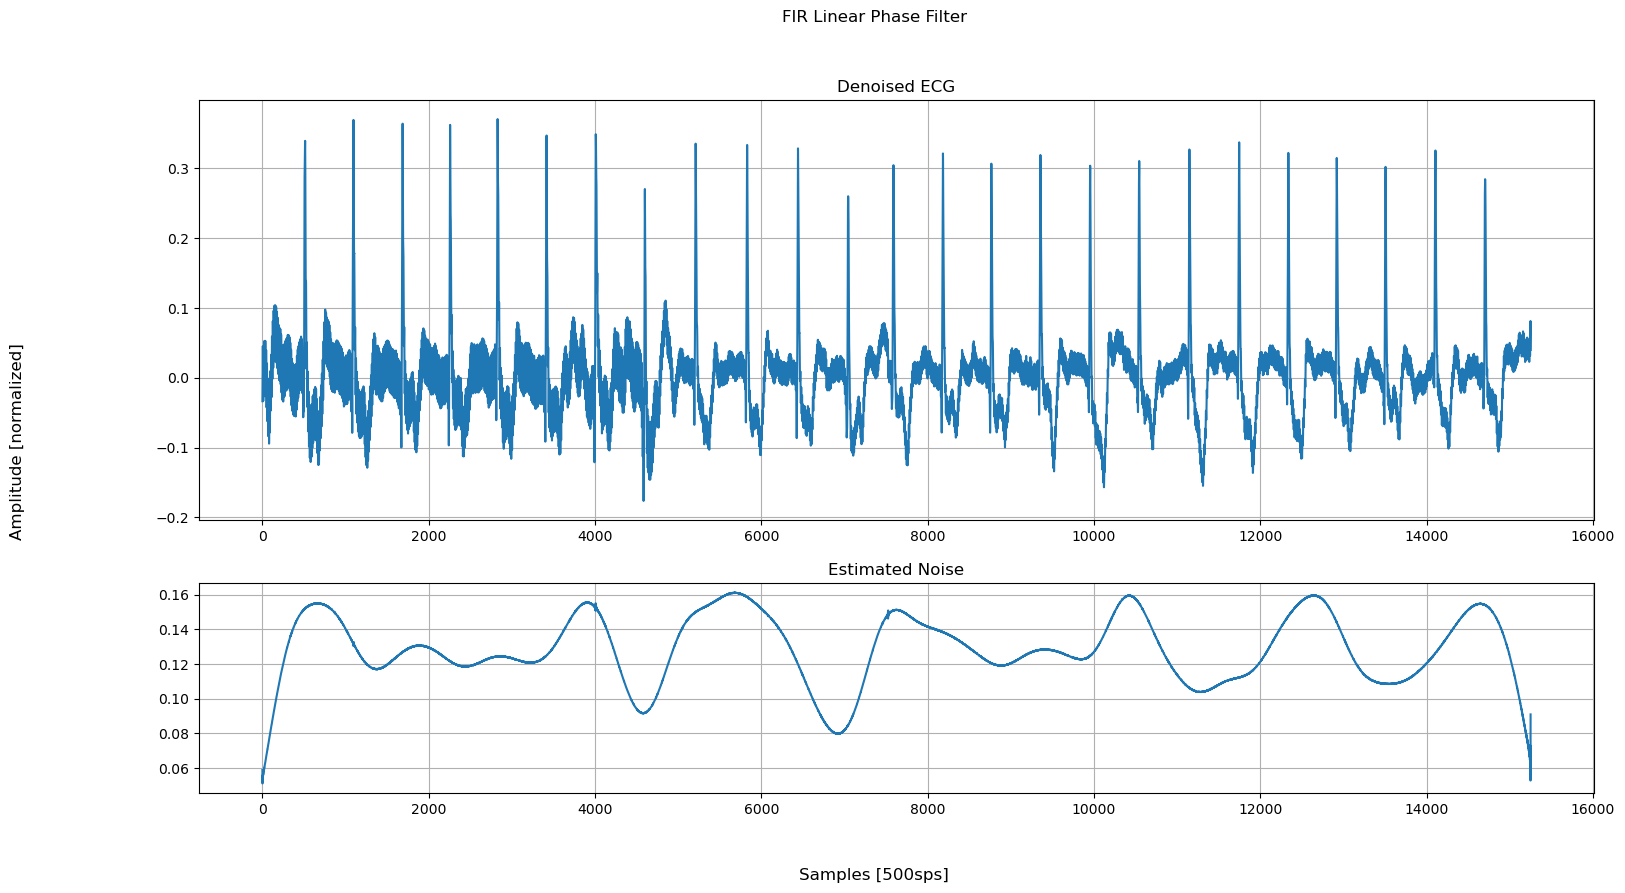

In [48]:
## Linear phase FIR
# Calculate FIR coefficients with window method
# Define the filter specifications
numtaps = 2001                  # Number of taps in the filter
cutoff = [(0.5)/(ECG_rate/2), (150)/(ECG_rate/2)]          # Passband frequencies (normalized, from 0 to 1, where 1 is the Nyquist frequency)
window = 'hamming'             # Window type

taps = signal.firwin(numtaps, cutoff, pass_zero=False, window=window)
# Filter Signal
ECG_FIR = np.convolve(ECG_v, taps, mode='same')
e_FIR = residuals (ECG_FIR, ECG_v)
# noise level metrics
mse_FIR =  meanSquareError(ECG_FIR, ECG_v)
dc_snr_FIR, ac_snr_FIR = detrendedSNR(ECG_FIR, e_FIR)
lf_snr_FIR, hf_snr_FIR = frequencySNR(ECG_FIR, e_FIR, 0.5)

# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('FIR Linear Phase Filter')
axs[0].plot(ECG_FIR)
axs[0].set_title('Denoised ECG')
axs[0].grid()
axs[1].plot(e_FIR)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [500sps]')
fig.supylabel('Amplitude [normalized]')

## IIR Implementation (Not Possible in online computing)

Text(0.02, 0.5, 'Amplitude [normalized]')

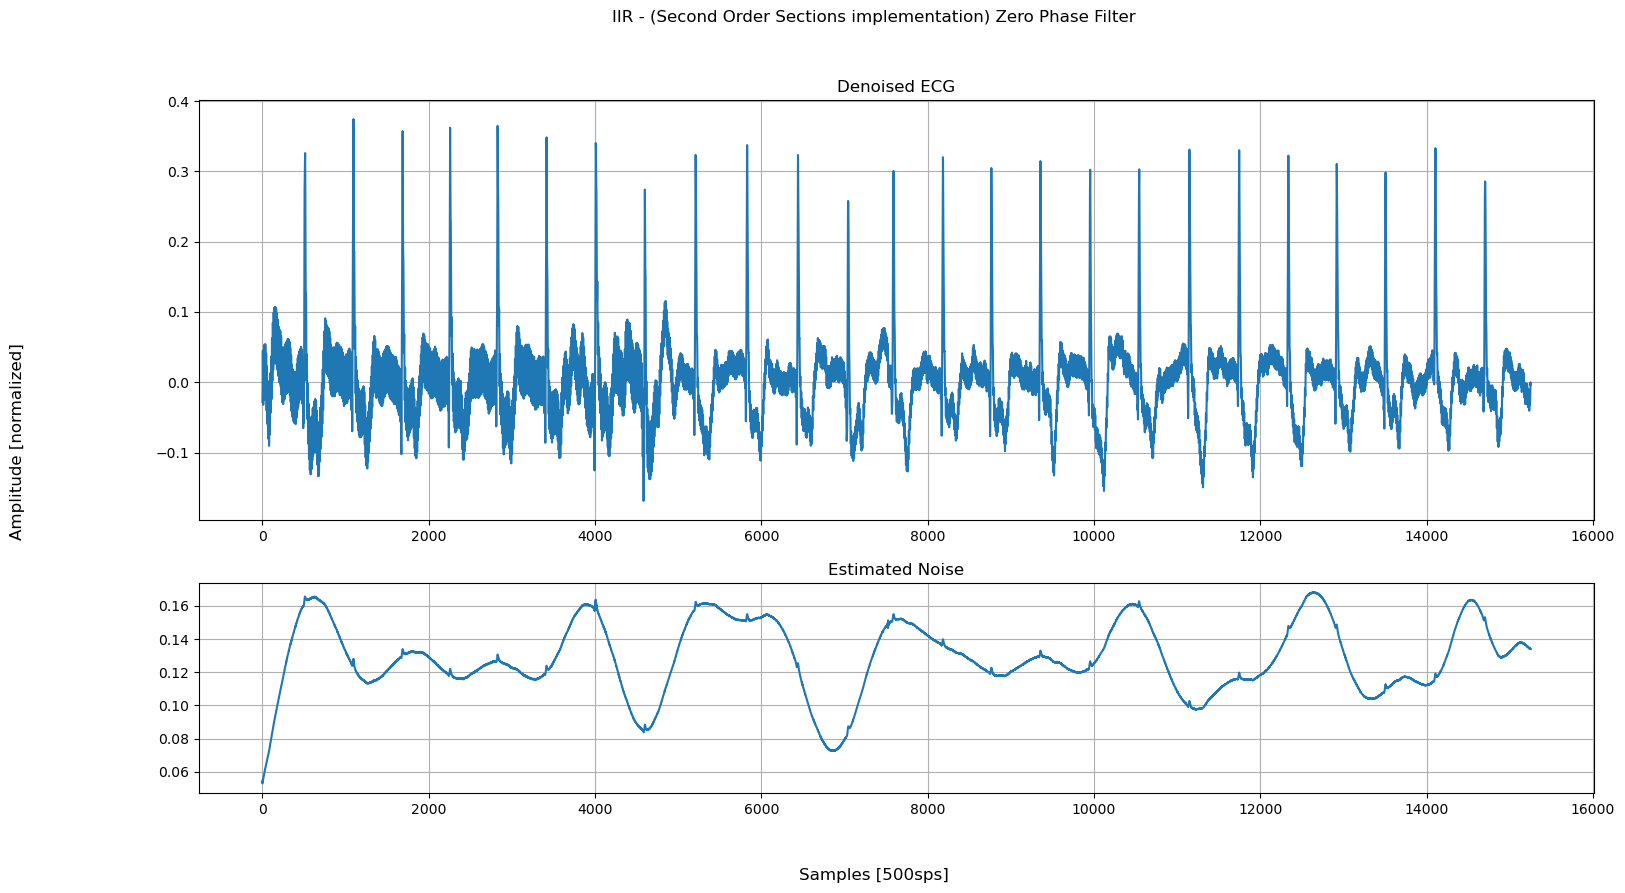

In [50]:
# Signal Denoise
ECG_IIR = bandPassButterworth(ECG_v, 0.5, 150, 16, ECG_rate)
e_IIR = residuals (ECG_IIR, ECG_v)
# noise level metrics
mse_IIR =  meanSquareError(ECG_IIR, ECG_v)
dc_snr_IIR, ac_snr_IIR = detrendedSNR(ECG_IIR, e_IIR)
lf_snr_IIR, hf_snr_IIR = frequencySNR(ECG_IIR, e_IIR, 0.5)

# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('IIR - (Second Order Sections implementation) Zero Phase Filter')
axs[0].plot(ECG_IIR)
axs[0].set_title('Denoised ECG')
axs[0].grid()
axs[1].plot(e_IIR)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [500sps]')
fig.supylabel('Amplitude [normalized]')

# Results Comparison

In [52]:
from IPython.display import Markdown, display

# Create the markdown table
table_md = f"""
| Method                                | MSE                    | DC Relative Distortion   | AC SNR                  | LF Relative Distortion   | HF SNR                 | 
| ------                                | ---                    | ------                   | ------                  | ------                   | ----                   | 
| Approximation Elimination - Universal | {mse_universal2*100}   | {dc_snr_universal_2}     | {ac_snr_universal_2}    | {lf_snr_universal_2}     | {hf_snr_universal_2}   |
| SURE                                  | {mse_sure*100}         | {dc_snr_sure}            | {ac_snr_sure}           | {lf_snr_sure}            | {hf_snr_sure}          | 
| BayesShrink                           | {mse_bayeshrink*100}   | {dc_snr_bayeshrink}      | {ac_snr_bayeshrink}     | {lf_snr_bayeshrink}      | {hf_snr_bayeshrink}    |
| NormalShrink                          | {mse_normalshrink*100} | {dc_snr_normalshrink}    | {ac_snr_normalshrink}   | {lf_snr_normalshrink}    | {hf_snr_normalshrink}  |
| FDR Thresholding                      | {mse_fdr*100}          | {dc_snr_fdr}             | {ac_snr_fdr}            | {lf_snr_fdr}             | {hf_snr_fdr}           |
| FIR                                   | {mse_FIR*100}          | {dc_snr_FIR}             | {ac_snr_FIR}            | {lf_snr_FIR}             | {hf_snr_FIR}           |  
| IIR                                   | {mse_IIR*100}          | {dc_snr_IIR}             | {ac_snr_IIR}            | {lf_snr_IIR}             | {hf_snr_IIR}           | 
"""

display(Markdown(table_md))


| Method                                | MSE                    | DC Relative Distortion   | AC SNR                  | LF Relative Distortion   | HF SNR                 | 
| ------                                | ---                    | ------                   | ------                  | ------                   | ----                   | 
| Approximation Elimination - Universal | 1.6992409983637362   | -61.91355810607569     | 9.741615554910785    | -24.772075099567136     | 11.770447852259611   |
| SURE                                  | 1.6982649343108531         | -61.957656860748116            | 10.012153163386694           | -24.651893271117714            | 12.09369501547645          | 
| BayesShrink                           | 1.6982651149377956   | -61.95726742213391      | 10.01089869673089     | -24.652868996082397      | 12.092504967005894    |
| NormalShrink                          | 1.7005027610318368 | -61.94216637732015    | 9.693287422967437   | -24.701863755575836    | 11.653714729084951  |
| FDR Thresholding                      | 1.698264568142752          | -61.95638964394881             | 10.011303472995902            | -24.652532380984784             | 12.092887022117742           |
| FIR                                   | 1.6932910631846778          | -51.33755104736665             | 9.77499025151241            | -25.28703481522481             | 12.399588855871821           |  
| IIR                                   | 1.7047545980851693          | -55.882492689684526             | 8.882096013155747            | -26.78587142265989             | 12.31625436868679           | 


# Observations and results

Paradoxically, the best results are obtained by the Normal Shrink followed by Universal. Both are the lightest computation methods.

**need to explore more filtering quality metrics**


# PCG Processing

## Denoising specific structure

In [56]:
def PCGWVDenoise(signal, threshold):
    wv_coeffs = pywt.wavedec(signal, wavelet='coif4', level=6)
    sigma = np.median(abs(wv_coeffs[-4]))/0.674
    for i in range(len(wv_coeffs)):
        lbda = threshold(wv_coeffs[i], sigma)
        wv_coeffs[i] = softThreshold (wv_coeffs[i], lbda)
    wv_coeffs[0] -= np.mean(wv_coeffs[0])
    wv_coeffs[-1][:] = 0
    wv_coeffs[-2][:] = 0
    wv_coeffs[-3][:] = 0
    return pywt.waverec(wv_coeffs, wavelet='coif4')

[]

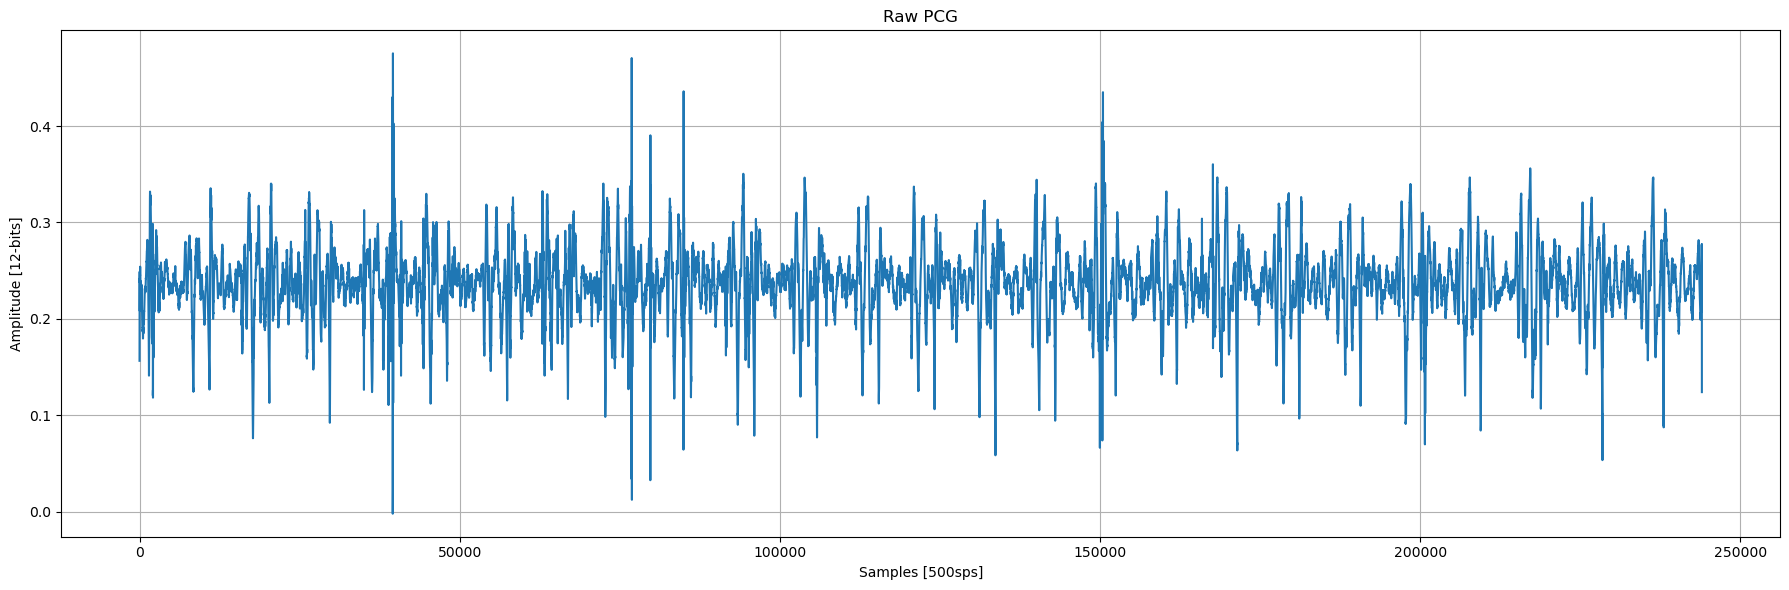

In [57]:
## Normalize full-scale
PCG_v = (PCG ) / (PCG_resolution) #uint 16 bits (scale -0.5;0.5)

plt.figure(figsize=(18, 6))
plt.plot(PCG_v)
plt.grid()
plt.xlabel('Samples [500sps]')
plt.ylabel('Amplitude [12-bits]')
plt.title('Raw PCG')
plt.tight_layout()

plt.plot()

In [58]:
# playback reconstructed
#sd.play(PCG_v,PCG_rate)
#time.sleep(t)
#sd.stop()

## Lambda tests

### Universal

Text(0.02, 0.5, 'Amplitude [normalized]')

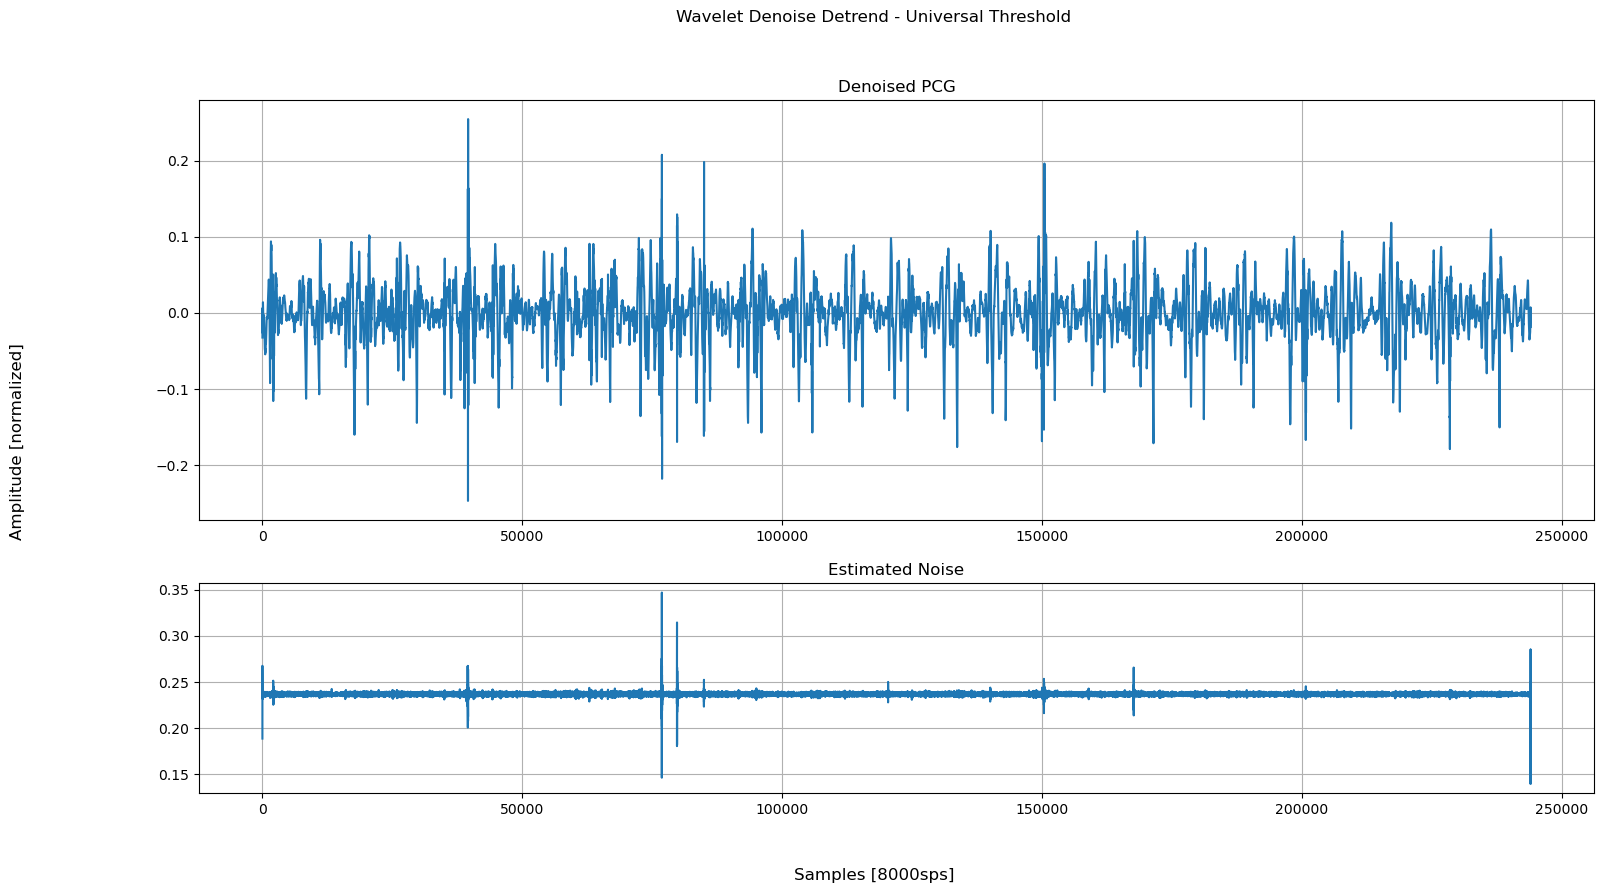

In [61]:
# Signal Denoise
PCG_wv_universal = PCGWVDenoise(PCG_v, universal)
PCG_e_universal = residuals (PCG_wv_universal, PCG_v)
# noise level metrics
mse_universal_pcg =  meanSquareError(PCG_wv_universal, PCG_v)
dc_snr_universal_pcg, ac_snr_universal_pcg = detrendedSNR(PCG_wv_universal, PCG_e_universal)
#lf_snr_universal_pcg, hf_snr_universal_pcg = frequencySNR(PCG_wv_universal3, PCG_e_universal, 0.5)

# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('Wavelet Denoise Detrend - Universal Threshold')
axs[0].plot(PCG_wv_universal)
axs[0].set_title('Denoised PCG')
axs[0].grid()
axs[1].plot(PCG_e_universal)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [8000sps]')
fig.supylabel('Amplitude [normalized]')

In [62]:
# playback reconstructed
#sd.play(PCG_wv_universal,PCG_rate)
#time.sleep(t)
#sd.stop()

### SURE

Text(0.02, 0.5, 'Amplitude [normalized]')

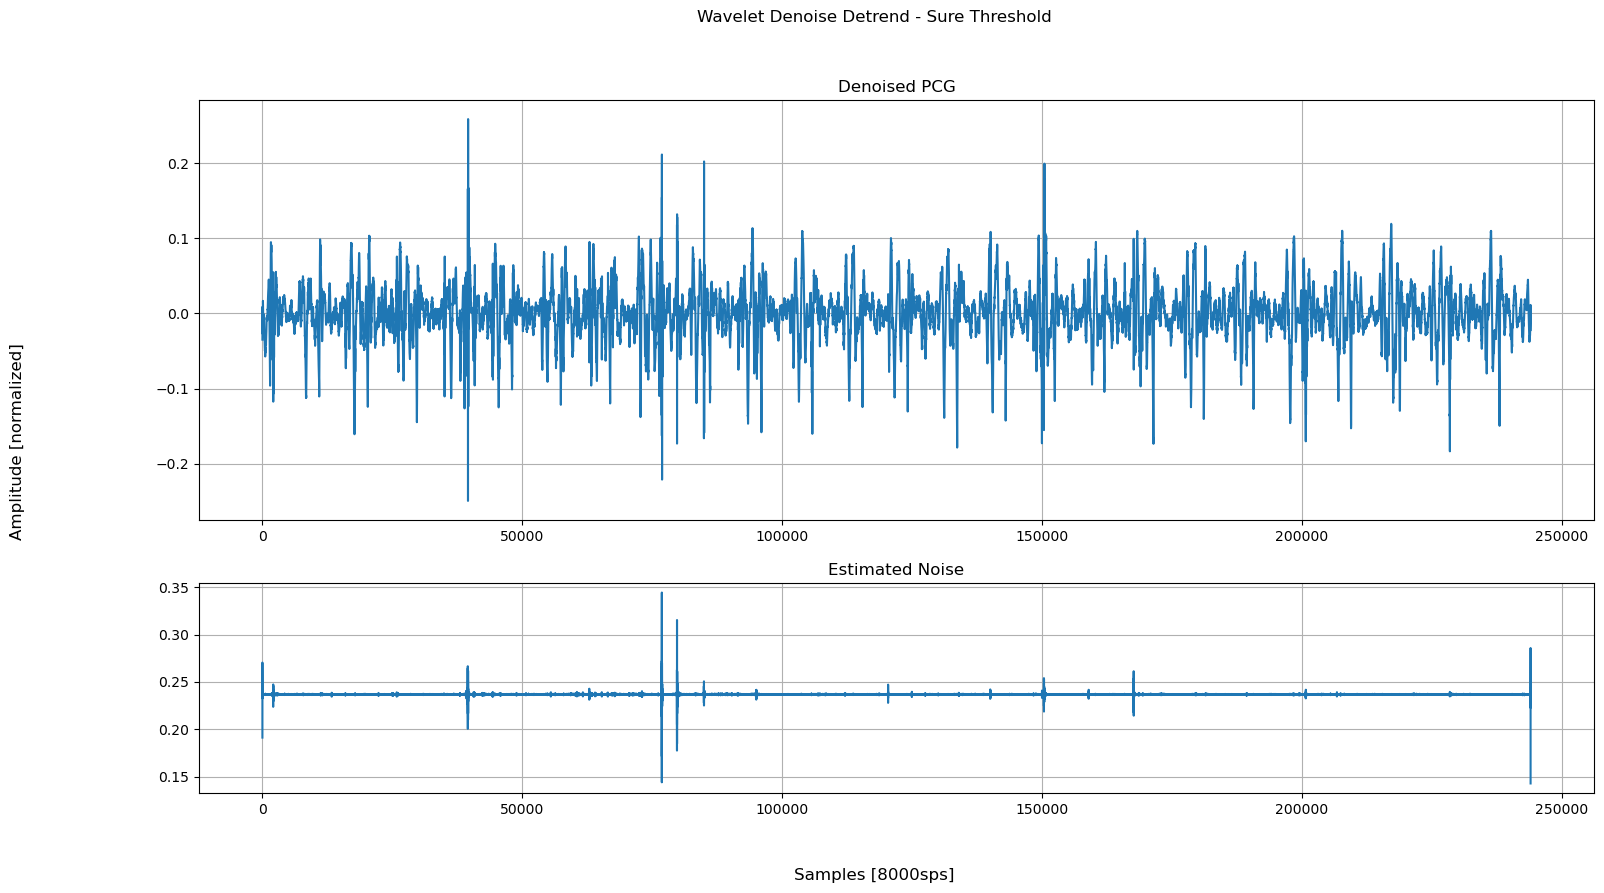

In [64]:
# Signal Denoise
PCG_wv_sure = PCGWVDenoise(PCG_v, sureLambda)
PCG_e_sure = residuals (PCG_wv_sure, PCG_v)
# noise level metrics
mse_sure_pcg =  meanSquareError(PCG_wv_sure, PCG_v)
dc_snr_sure_pcg, ac_snr_sure_pcg = detrendedSNR(PCG_wv_sure, PCG_e_sure)
#lf_snr_universal_pcg, hf_snr_universal_pcg = frequencySNR(PCG_wv_universal3, PCG_e_universal, 0.5)

# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('Wavelet Denoise Detrend - Sure Threshold')
axs[0].plot(PCG_wv_sure)
axs[0].set_title('Denoised PCG')
axs[0].grid()
axs[1].plot(PCG_e_sure)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [8000sps]')
fig.supylabel('Amplitude [normalized]')

### BayesShrink

Text(0.02, 0.5, 'Amplitude [normalized]')

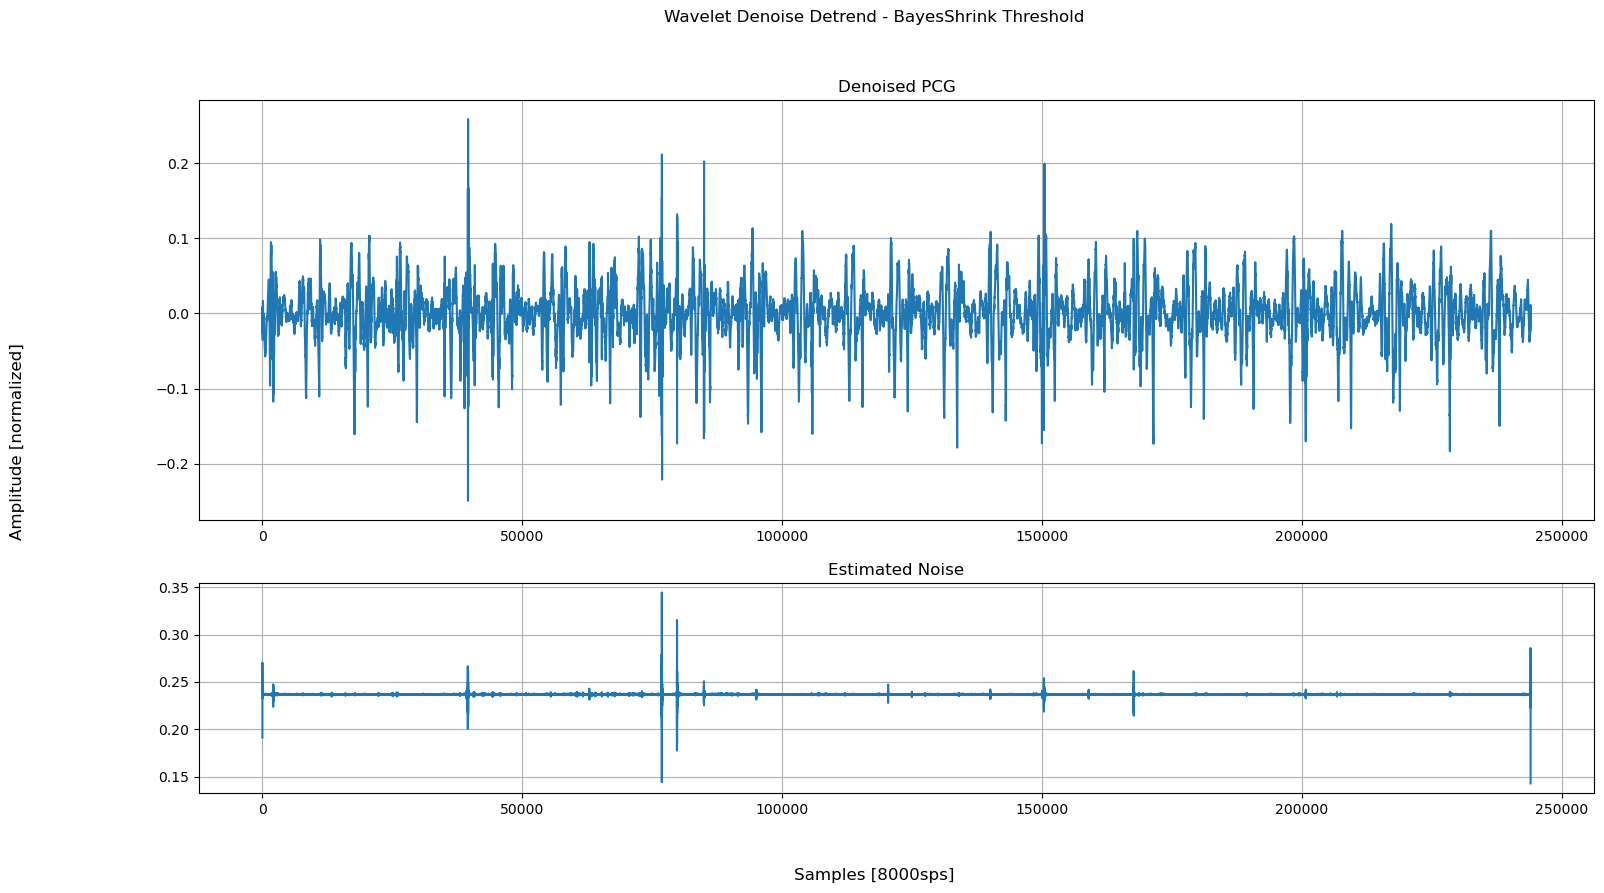

In [66]:
# Signal Denoise
PCG_wv_bayes = PCGWVDenoise(PCG_v, bayesshrink_lambda)
PCG_e_bayes = residuals (PCG_wv_bayes, PCG_v)
# noise level metrics
mse_bayes_pcg =  meanSquareError(PCG_wv_bayes, PCG_v)
dc_snr_bayes_pcg, ac_snr_bayes_pcg = detrendedSNR(PCG_wv_bayes, PCG_e_bayes)
#lf_snr_universal_pcg, hf_snr_universal_pcg = frequencySNR(PCG_wv_universal3, PCG_e_universal, 0.5)

# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('Wavelet Denoise Detrend - BayesShrink Threshold')
axs[0].plot(PCG_wv_bayes)
axs[0].set_title('Denoised PCG')
axs[0].grid()
axs[1].plot(PCG_e_bayes)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [8000sps]')
fig.supylabel('Amplitude [normalized]')

In [67]:
# playback reconstructed
#sd.play(PCG_wv_bayes,PCG_rate)
#time.sleep(t)
#sd.stop()

### NormalShrink

Text(0.02, 0.5, 'Amplitude [normalized]')

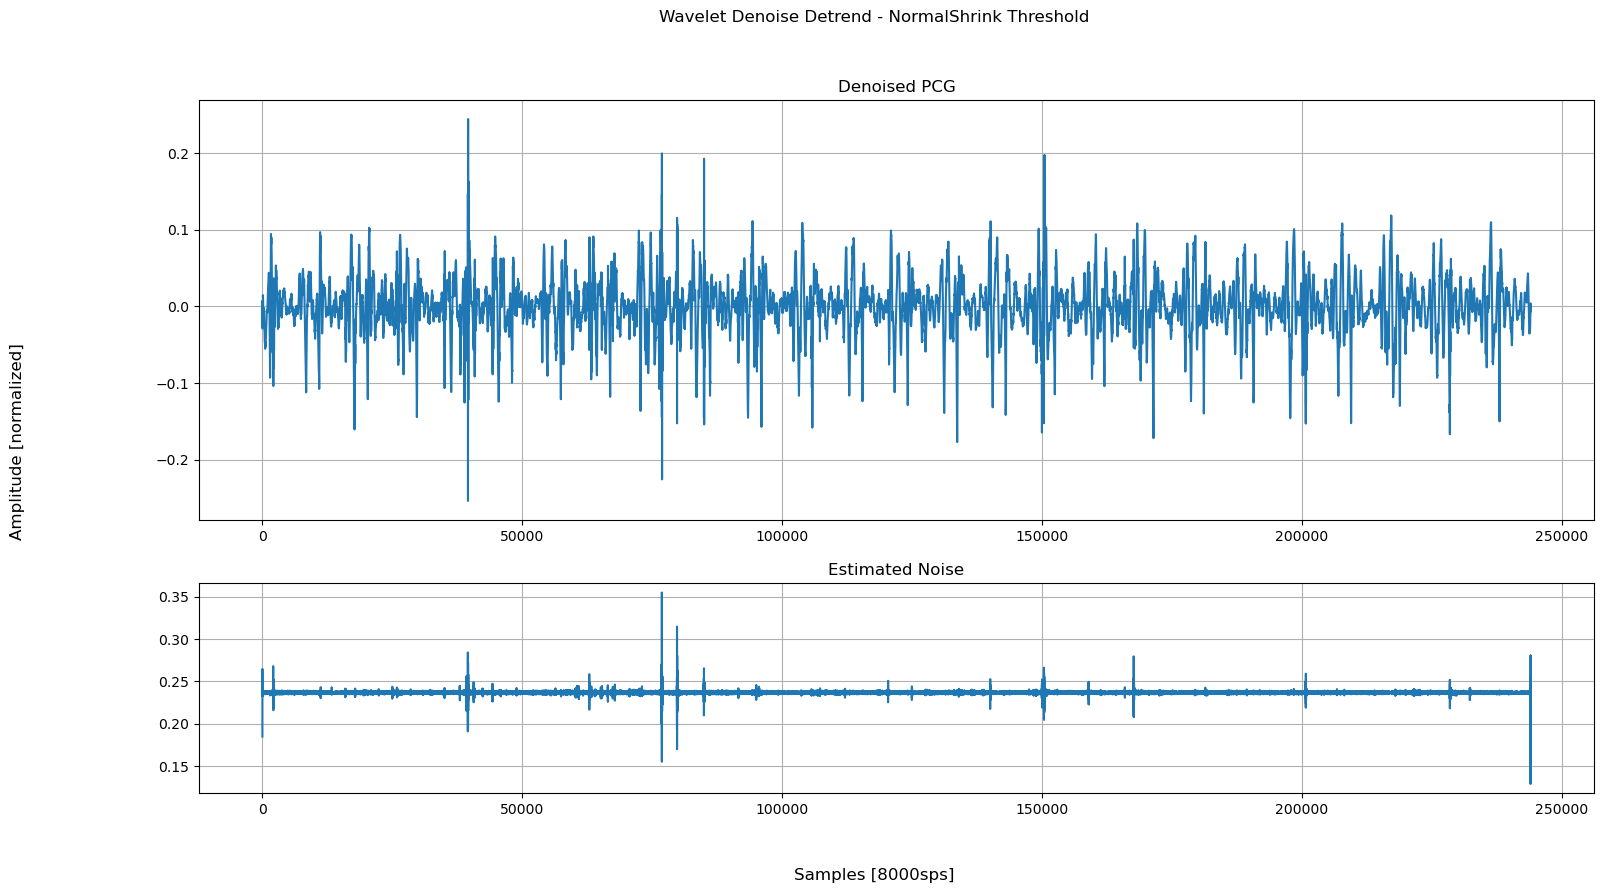

In [69]:
# Signal Denoise
PCG_wv_normal = PCGWVDenoise(PCG_v, normalshrink_lambda)
PCG_e_normal = residuals (PCG_wv_normal, PCG_v)
# noise level metrics
mse_normal_pcg =  meanSquareError(PCG_wv_normal, PCG_v)
dc_snr_normal_pcg, ac_snr_normal_pcg = detrendedSNR(PCG_wv_normal, PCG_e_normal)
#lf_snr_universal_pcg, hf_snr_universal_pcg = frequencySNR(PCG_wv_universal3, PCG_e_universal, 0.5)

# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('Wavelet Denoise Detrend - NormalShrink Threshold')
axs[0].plot(PCG_wv_normal)
axs[0].set_title('Denoised PCG')
axs[0].grid()
axs[1].plot(PCG_e_normal)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [8000sps]')
fig.supylabel('Amplitude [normalized]')

In [70]:
# playback reconstructed
#sd.play(PCG_wv_normal,PCG_rate)
#time.sleep(t)
#sd.stop()

### Control FIR

Text(0.02, 0.5, 'Amplitude [normalized]')

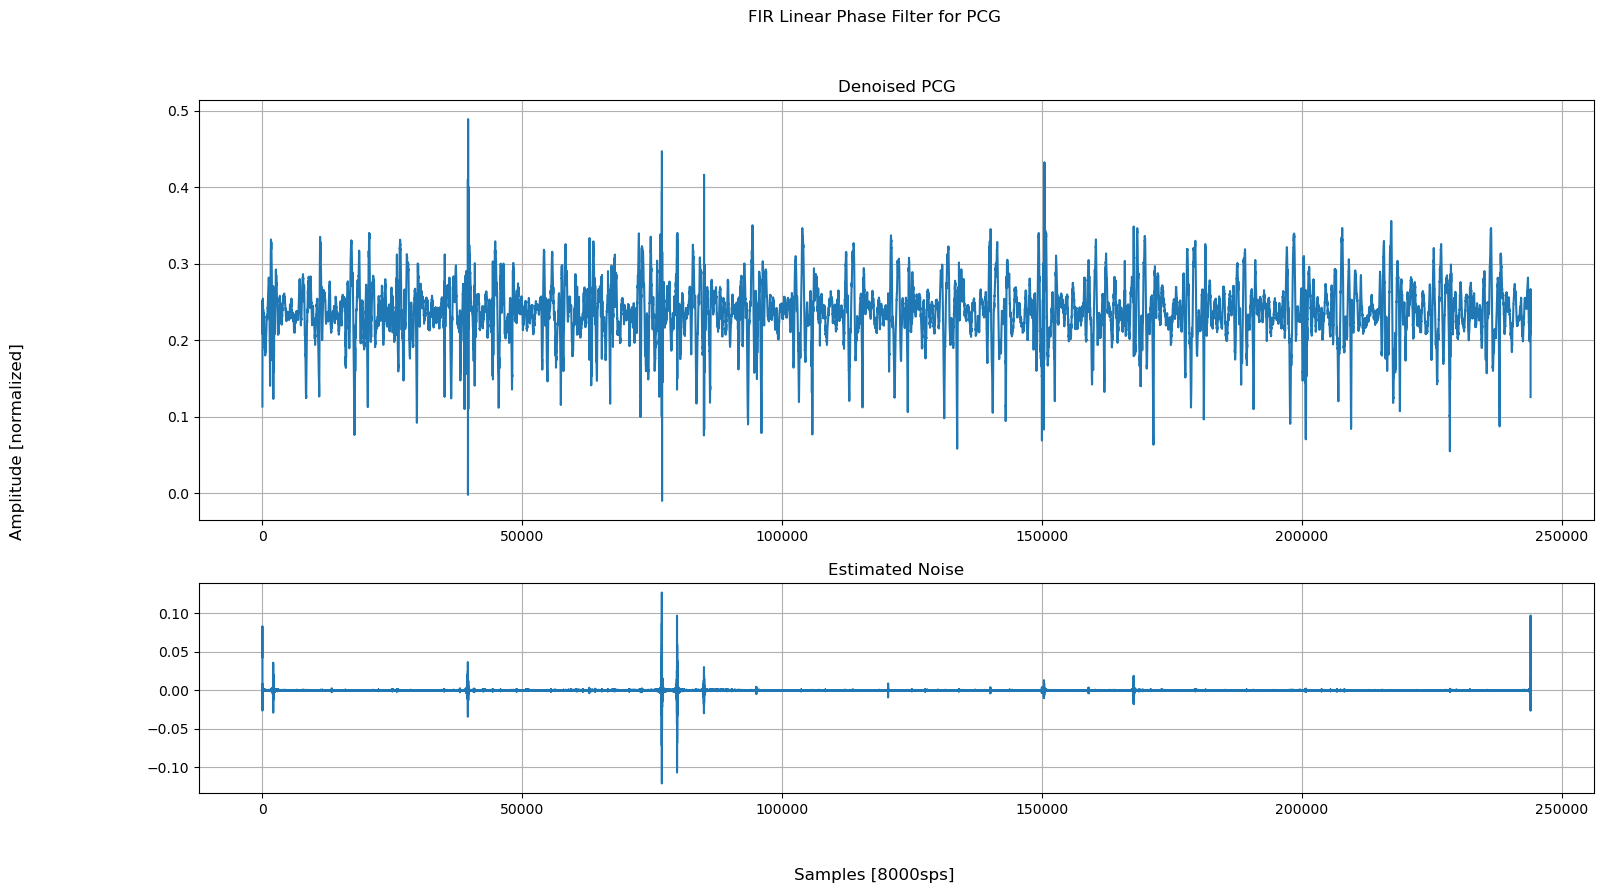

In [72]:
## Linear phase FIR
# Calculate FIR coefficients with window method
# Define the filter specifications
numtaps = 32001                  # Number of taps in the filter
cutoff = (450)/(PCG_rate/2)          # Passband frequencies (normalized, from 0 to 1, where 1 is the Nyquist frequency)
window = 'hamming'             # Window type

taps = signal.firwin(numtaps, cutoff, window=window)
# Filter Signal
PCG_FIR = np.convolve(PCG_v, taps, mode='same')
e_FIR_PCG = residuals (PCG_FIR, PCG_v)
# noise level metrics
mse_FIR_PCG =  meanSquareError(PCG_FIR, PCG_v)
dc_snr_FIR_PCG, ac_snr_FIR_PCG = detrendedSNR(PCG_FIR, e_FIR_PCG)
#lf_snr_FIR_PCG, hf_snr_FIR_PCG = frequencySNR(PCG_FIR, e_FIR_PCG, 0.5)

# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('FIR Linear Phase Filter for PCG')
axs[0].plot(PCG_FIR)
axs[0].set_title('Denoised PCG')
axs[0].grid()
axs[1].plot(e_FIR_PCG)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [8000sps]')
fig.supylabel('Amplitude [normalized]')

In [73]:
# playback reconstructed
#sd.play(PCG_FIR,PCG_rate)
#time.sleep(t)
#sd.stop()

### Control IIR

In [75]:
# Signal Denoise
PCG_IIR = lowPassButterworth(ECG_v, 450, 16, PCG_rate)
e_IIR_PCG = residuals (PCG_IIR, PCG_v)
# noise level metrics
mse_IIR_PCG =  meanSquareError(PCG_IIR, PCG_v)
dc_snr_IIR_PCG, ac_snr_IIR_PCG = detrendedSNR(PCG_IIR, e_IIR_PCG)
#lf_snr_IIR, hf_snr_IIR = frequencySNR(ECG_IIR, e_IIR, 0.5)

# plot
#Plot data
fig, axs = plt.subplots(2,1,figsize=(18,9), gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle('IIR - (Second Order Sections implementation) Zero Phase Filter for PCG')
axs[0].plot(PCG_IIR)
axs[0].set_title('Denoised PCG')
axs[0].grid()
axs[1].plot(e_IIR_PCG)
axs[1].set_title('Estimated Noise')
axs[1].grid()
fig.supxlabel('Samples [8000sps]')
fig.supylabel('Amplitude [normalized]')

ValueError: operands could not be broadcast together with shapes (243997,) (15250,) 

In [ ]:
# playback reconstructed
#sd.play(PCG_IIR,PCG_rate)
#time.sleep(t)
#sd.stop()

# Observations PCG Wavelet denoise

I need to create another structure that zeores high frequency bands, forcing the retention and denoising of exclussively the bands of interest